In [2]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

In [3]:
# pip install -q catboost

In [4]:
# pip install "numpy<2.0"


In [5]:
# pip install shap

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [ ]:
import pandas as pd
df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# 1. OVERVIEW

## 1.1. Overview about dataset

### 1.1.1. shape
- tập dữ liệu bao gồm 7043 bản ghi
- 21 cột dữ liệu với 20 đặc trưng (features) và 1 cột nhãn (label)

In [8]:
df.shape

(7043, 21)

### 1.1.2. info()
- không chứa giá trị null
- đa số là kiểu dữ liệu object (categorical).
- TotalCharges có thể là numeric (NOTE)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


###  1.1.3. unique()
Giá trị unique của 1 số đặc trưng:
- customerID: định danh khách hàng, không có giá trị phân tích, có thể loại bỏ
- Gender: Female, Male.
- SeniorCitizen: Khách hàng lớn tuổi (1: đúng; 0: không đúng)
- Partner: khách hàng có vợ/chồng hay không (['Yes', 'No'])
- Dependents: khách hàng có người phụ thuộc hay không (['Yes', 'No'])
- tenure: thời gian khách hàng đã gắn bó (tháng) - tuổi hợp đồng.
- PhoneService: Khách hàng có sử dụng điện thoại hay không (['Yes', 'No'])
- MultiplesLines: Khách hàng có nhiều đường dây điện thoại không (['No phone service', 'No', 'Yes'])
- InternetService: loại kết nối Internet khách hàng sử dụng (['DSL', 'Fiber optic', 'No'])
- OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies: các dịch vụ bổ sung liên quan đến Internet (['No', 'Yes', 'No internet service'])
-> (ta có thể tạo feature mới - số lượng dịch vụ khách hàng sử dụng).
- Contract: Loại hợp đồng (Month-to-Month, One Year, Two Year).
- PaperlessBilling: Khách hàng sử dụng thanh toán điện tử (['Yes' 'No'])
- PaymentMethod: phương thức thanh toán (['Electronic check' 'Mailed check' 'Bank transfer (automatic)','Credit card (automatic)'])
- MonthlyCharges: chi phí hằng tháng.
- TotalCharges: tổng chi tiêu.

Nhãn dữ liệu (label):
- Churn: khách hàng rời bỏ - không rời bỏ (['No', 'Yes'])

Mỗi quan hệ giữa 1 số đặc trưng:
- Nếu khách hàng không sử dụng dịch vụ Internet (InternetService = 'No') thì họ các dịch vụ kèm theo nhận giá trị 'No internet service'.


### 1.1.4. Problem Statement - Đặt vấn đề
Mục tiêu cuối cùng là 'Tăng lợi nhuận' cho công ty. Điều này có thể thực hiện được thông qua:

- Thu hút nhiều khách hàng mới nhất có thể.
- Giữ chân nhiều khách hàng hiện tại nhất có thể.

Vấn đề

- Chi phí đầu tư để có được 1 khách hàng mới là rất lớn, có thể tốn đến 15 tháng mới có thể thu hồi được vốn đầu tư.
- Khi một khách hàng rời bỏ dịch vụ, mất mát của doanh nghiệp là rất lớn.
- Việc có được khách hàng mới thường khó khăn hơn và tốn kém hơn so với việc giữ chân khách hàng hiện tại.

Mục tiêu

- Mô hình dự đoán liệu khách hàng có tiếp tục sử dụng dịch vụ hay sẽ rời bỏ.
- Hiểu được hành của khách hàng:

  - điều gì khiến khách hàng tiếp tục sử dụng dịch vụ (có thể nhìn vào nhóm khách hàng có tenure cao).
  - điều gì khiến khách hàng rời khỏi dịch vụ.

In [10]:
for col in df.columns:
    print(f"Unique values in '{col}':")
    print(df[col].unique())
    print("-" * 40)


Unique values in 'customerID':
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
----------------------------------------
Unique values in 'gender':
['Female' 'Male']
----------------------------------------
Unique values in 'SeniorCitizen':
[0 1]
----------------------------------------
Unique values in 'Partner':
['Yes' 'No']
----------------------------------------
Unique values in 'Dependents':
['No' 'Yes']
----------------------------------------
Unique values in 'tenure':
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
----------------------------------------
Unique values in 'PhoneService':
['No' 'Yes']
----------------------------------------
Unique values in 'MultipleLines':
['No phone service' 'No' 'Yes']
----------------------------------------
Unique values in 'Inter

##  1.2. duplicate values: 0

In [11]:
df.duplicated().sum()

0

## 1.3. NULL values: 0

In [12]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

## 1.4. drop customerID: (unique)

- giá trị của Cột CustomerID là Unique, chỉ mang tính phân biệt các bản ghi nên ta có thể loại bỏ

In [13]:
df.drop('customerID', axis=1, inplace=True)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 1.5. Column Rename: naming convention - snake_case

- chuyển đổi tên cột theo cách đặt tên thống nhất: snake_case

In [14]:
# pip install inflection

In [15]:
import inflection
column_list = list(df.columns)

for i, col in enumerate(column_list):
  column_list[i] = inflection.underscore(column_list[i]).replace(' ', '_')

df.columns = column_list

In [16]:
df.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 1.6. create df for column's data type: numerical - categorial

In [17]:
# numerical
column_numerical = ['tenure', 'monthly_charges', 'total_charges']

#categorical
column_categorical = list(df.columns)
column_categorical.remove('tenure')
column_categorical.remove('monthly_charges')
column_categorical.remove('total_charges')

data_type_general = dict()

for col in df.columns:
  if col in column_numerical:
    data_type_general[col] = 'numerical'
  else:
    data_type_general[col] = 'categorical'

temp = pd.Series(data_type_general)
data_type_general =pd.DataFrame(temp).T.rename({0: 'general data types'})
data_type_general


,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
general data types,categorical,categorical,categorical,categorical,numerical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,numerical,numerical,categorical


## 1.7. data type

In [18]:
data_type_python = pd.DataFrame(df.dtypes).T.rename({0: 'python data types'})
data_type_python

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
python data types,object,int64,object,object,int64,object,object,object,object,object,object,object,object,object,object,object,object,float64,object,object


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7043 non-null   object 
 1   senior_citizen     7043 non-null   int64  
 2   partner            7043 non-null   object 
 3   dependents         7043 non-null   object 
 4   tenure             7043 non-null   int64  
 5   phone_service      7043 non-null   object 
 6   multiple_lines     7043 non-null   object 
 7   internet_service   7043 non-null   object 
 8   online_security    7043 non-null   object 
 9   online_backup      7043 non-null   object 
 10  device_protection  7043 non-null   object 
 11  tech_support       7043 non-null   object 
 12  streaming_tv       7043 non-null   object 
 13  streaming_movies   7043 non-null   object 
 14  contract           7043 non-null   object 
 15  paperless_billing  7043 non-null   object 
 16  payment_method     7043 

### 1.7.1. xử lý dữ liệu cột total_charges

In [20]:
df.describe()

,senior_citizen,tenure,monthly_charges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [21]:
# non_numeric_values = df[~df['total_charges'].apply(lambda x: str(x).replace('.','', 1).isdigit())]
# non_numeric_values
non_numeric_values = df[pd.to_numeric(df['total_charges'], errors='coerce').isna()]
non_numeric_values

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


NOTE:
- total_charges có data type = object -> có dữ liệu khác numeric
  - tenure: min value = 0 - khách hàng mới vừa đăng ký - chưa thanh toán cước.
  - các bản ghi có tenure = 0 có giá trị total_charges rỗng (blank)

=> Thay thế bằng giá trị 0 cho các giá trị không đúng ở cột total_charges

In [22]:
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')
df.fillna({'total_charges': 0}, inplace=True)
# df['total_charges'] = df['total_charges'].fillna(0)

In [23]:
non_numeric_values = df[pd.to_numeric(df['total_charges'], errors='coerce').isna()]
non_numeric_values

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn


In [24]:
df['total_charges'] = df['total_charges'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7043 non-null   object 
 1   senior_citizen     7043 non-null   int64  
 2   partner            7043 non-null   object 
 3   dependents         7043 non-null   object 
 4   tenure             7043 non-null   int64  
 5   phone_service      7043 non-null   object 
 6   multiple_lines     7043 non-null   object 
 7   internet_service   7043 non-null   object 
 8   online_security    7043 non-null   object 
 9   online_backup      7043 non-null   object 
 10  device_protection  7043 non-null   object 
 11  tech_support       7043 non-null   object 
 12  streaming_tv       7043 non-null   object 
 13  streaming_movies   7043 non-null   object 
 14  contract           7043 non-null   object 
 15  paperless_billing  7043 non-null   object 
 16  payment_method     7043 

In [25]:
data_type_python = pd.DataFrame(df.dtypes).T.rename({0:'python data types'})
data_type_python

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
python data types,object,int64,object,object,int64,object,object,object,object,object,object,object,object,object,object,object,object,float64,float64,object


## 1.8. Data Range (numerical)

In [26]:
variation_numerical = dict()

for col in column_numerical:
  tmp = f'{df[col].min()} - {df[col].max()}'
  variation_numerical[col] = tmp

tmp = pd.Series(variation_numerical)
data_variation_numerical = pd.DataFrame(tmp).T.rename({0:'data variation'})
data_variation_numerical

,tenure,monthly_charges,total_charges
data variation,0 - 72,18.25 - 118.75,0.0 - 8684.8


## 1.9. Unique values - Categorical Data

In [27]:
variation_categorical = dict()

for col in column_categorical:
  tmp = df[col].unique().tolist()
  tmp.sort()
  variation_categorical[col] = ', '.join(str(item) for item in tmp)

tmp = pd.Series(variation_categorical)
data_variation_categorical = pd.DataFrame(tmp).T.rename({0:'data variation'})
data_variation_categorical

,gender,senior_citizen,partner,dependents,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,churn
data variation,"Female, Male","0, 1","No, Yes","No, Yes","No, Yes","No, No phone service, Yes","DSL, Fiber optic, No","No, No internet service, Yes","No, No internet service, Yes","No, No internet service, Yes","No, No internet service, Yes","No, No internet service, Yes","No, No internet service, Yes","Month-to-month, One year, Two year","No, Yes","Bank transfer (automatic), Credit card (automa...","No, Yes"


In [28]:
df = df.replace({'No phone service': 'No',
                 'No internet service': 'No'})

df['senior_citizen'] = df['senior_citizen'].replace({0: 'No', 1: 'Yes'})

## 1.10. Overall

In [29]:
data_variation = pd.concat([data_variation_numerical, data_variation_categorical], axis=1)
data_variation

,tenure,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,churn
data variation,0 - 72,18.25 - 118.75,0.0 - 8684.8,"Female, Male","0, 1","No, Yes","No, Yes","No, Yes","No, No phone service, Yes","DSL, Fiber optic, No","No, No internet service, Yes","No, No internet service, Yes","No, No internet service, Yes","No, No internet service, Yes","No, No internet service, Yes","No, No internet service, Yes","Month-to-month, One year, Two year","No, Yes","Bank transfer (automatic), Credit card (automa...","No, Yes"


In [30]:
df.describe(include='all')

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
count,7043,7043,7043,7043,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043.000000,7043
unique,2,2,2,2,NaN,2,2,3,2,2,2,2,2,2,3,2,4,NaN,NaN,2
top,Male,No,No,No,NaN,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,NaN,No
freq,3555,5901,3641,4933,NaN,6361,4072,3096,5024,4614,4621,4999,4336,4311,3875,4171,2365,NaN,NaN,5174
mean,NaN,NaN,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,2279.734304,NaN
std,NaN,NaN,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,2266.794470,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,398.550000,NaN
50%,NaN,NaN,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,1394.550000,NaN
75%,NaN,NaN,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,3786.600000,NaN


In [31]:
pd.concat([data_variation_numerical.rename({'data variation':'range'}), data_variation_categorical.rename({'data variation':'variation'})], axis=0).fillna('-').reindex(df.columns, axis=1).T

,range,variation
gender,-,"Female, Male"
senior_citizen,-,"0, 1"
partner,-,"No, Yes"
dependents,-,"No, Yes"
tenure,0 - 72,-
phone_service,-,"No, Yes"
multiple_lines,-,"No, No phone service, Yes"
internet_service,-,"DSL, Fiber optic, No"
online_security,-,"No, No internet service, Yes"
online_backup,-,"No, No internet service, Yes"


# 2. EDA

In [32]:
column_categorical.remove('churn')

In [33]:
df_viz = df.copy()
df_viz.loc[:,'churn'] = df_viz.loc[:, 'churn'].apply(lambda x: 'churn' if x == 'Yes' else 'retain')

## 2.1. visualization func()

In [34]:
def stacked_bar_plot(data, x, y, orient='horizontal', ax=None, show=True):
  # create axis if not present
  if ax == None:
    _, ax = plt.subplots(figsize=(8,6))

  # create crosstab based on the input data
  crosstab = pd.crosstab(index=data[x], columns=data[y], normalize='index')
  crosstab = crosstab.reindex(['retain', 'churn'], axis=1)

  # visualize stacked barplot
  if orient == 'vertical':
    # order in descending (the highest value on the left)
    crosstab = crosstab.sort_values('churn', ascending=False)
    crosstab.plot(kind='bar', stacked=True, ax=ax)

    # add percentage label
    for i, index in enumerate(crosstab.index):
        for (proportion, y_loc) in zip(crosstab.loc[index], crosstab.loc[index].cumsum()):
          ax.text(x=i,
                  y=(y_loc - proportion) + (proportion / 2),
                  s=f'{proportion*100:.1f}%',
                  color='white',
                  fontsize=14,
                  fontweight='bold',
                  horizontalalignment='center',
                  verticalalignment='center')
    # remove tick labels
    ax.set_yticklabels([])
  else: # default is horizontal bar plot, even if the orient input is an arbitrary value
    # orient in ascending (the highest value on the top)
    crosstab = crosstab.sort_values('churn', ascending=True)
    crosstab.plot(kind='barh', stacked=True, ax=ax)

    # add percentage label
    for i, index in enumerate(crosstab.index):
        for (proportion, x_loc) in zip(crosstab.loc[index], crosstab.loc[index].cumsum()):
          ax.text(y=i,
                  x=(x_loc - proportion) + (proportion / 2),
                  s=f'{proportion*100:.1f}%',
                  color='white',
                  fontsize=14,
                  fontweight='bold',
                  horizontalalignment='center',
                  verticalalignment='center')
    # remove tick labels
    ax.set_xticklabels([])

  x_titleize = inflection.titleize(x)
  ax.set_title(f'Customer Churn Probability by {x_titleize}')
  ax.set_xlabel('')
  ax.set_ylabel('')
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='', frameon=False)
  # ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1), title='', ncol=2, frameon=False)
  sns.despine(left=True, bottom=True)

  if show:
    plt.show()

## 2.2. target distribution

- 27% khách hàng rời bỏ dịch vụ.
- Về mặt kỹ thuật, thì dữ liệu bị mất bằng.
- Nhưng thực tế thì phải mất cân bằng như vậy.

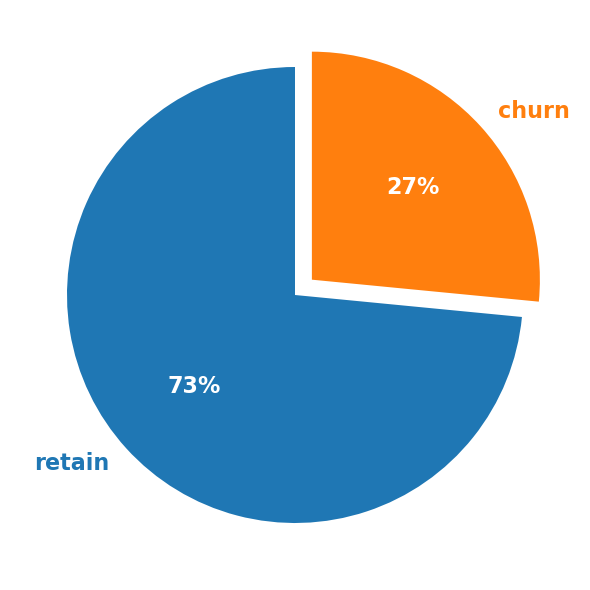

In [35]:
pie_data = df_viz['churn'].value_counts(normalize=True).values * 100
pie_label = df_viz['churn'].value_counts(normalize=True).index.to_list()

fig, ax = plt.subplots(figsize=(8,6))

wedges, texts, autotexts = ax.pie(pie_data, labels=pie_label,
                                  startangle=90, explode=[0, 0.1],
                                  autopct='%.0f%%',
                                  textprops={'color':'w', 'fontsize':16, 'weight':'bold'})

for i, wedge in enumerate(wedges):
  texts[i].set_color(wedge.get_facecolor())

plt.tight_layout()
plt.show()

## 2.3. relationship


### 2.3.1. gender vs. label

- Male và Female đều có churn rate như nhau.
- -> giới tính không liên quan đến việc khách hàng có rời bỏ hay không

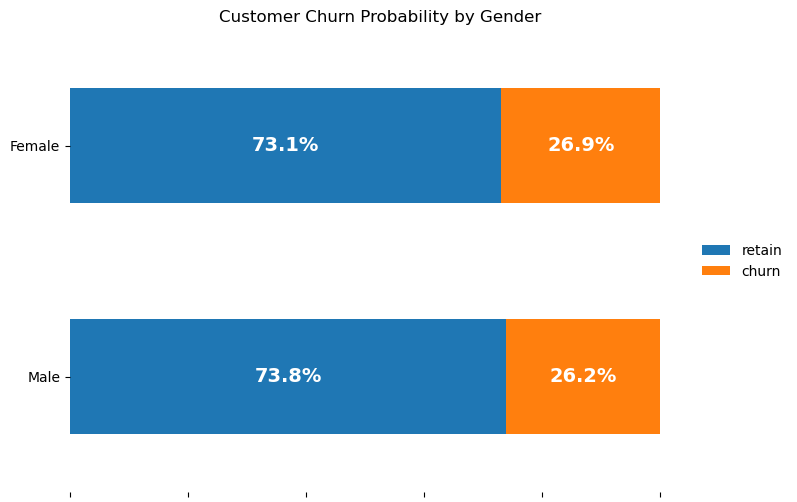

In [36]:
fig, ax = plt.subplots(figsize=(8,6))

stacked_bar_plot(data=df_viz, x='gender', y='churn', ax=ax)

### 2.3.2. SeniorCitizen vs. label

- người lớn tuổi có khả năng rời bỏ dịch vụ cao hơn người trẻ.
- -> có mối quan hệ với biến mục tiêu

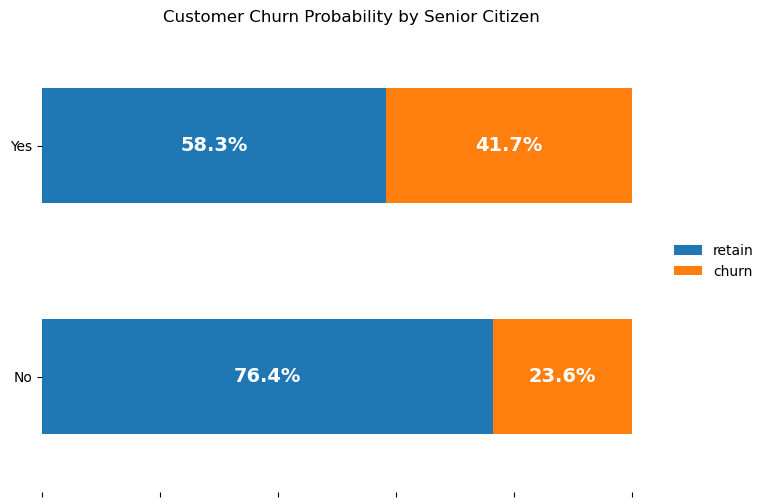

In [37]:
fig, ax = plt.subplots(figsize=(8,6))

stacked_bar_plot(data=df_viz, x='senior_citizen', y='churn', ax=ax)

### 2.3.3. Overall: categorical features vs. label

- Toàn bộ tỉ lệ rời bỏ của mỗi giá trị trong các biến categorial

In [38]:
columns = df_viz['churn']

attr_crosstab = pd.DataFrame()

for col in column_categorical:
  # create crosstab for each attribute
  index = df_viz[col]
  ct = pd.crosstab(index=index, columns=columns, normalize='index', colnames=[None]).reset_index()

  # add prefix to each category
  # format: column name (category)
  col_titleize = inflection.titleize(col)
  ct[col] = ct[col].apply(lambda x: f'{col_titleize} ({x})')

  # rename the column
  ct.rename(columns={col:'attribute'}, inplace=True)

  # create a single dataframe
  attr_crosstab = pd.concat([attr_crosstab, ct])

attr_crosstab = attr_crosstab.sort_values('churn', ascending=False).reset_index(drop=True)
attr_crosstab.style.background_gradient()

,attribute,churn,retain
0,Payment Method (Electronic check),0.452854,0.547146
1,Contract (Month-to-month),0.427097,0.572903
2,Internet Service (Fiber optic),0.418928,0.581072
3,Senior Citizen (Yes),0.416813,0.583187
4,Paperless Billing (Yes),0.335651,0.664349
5,Partner (No),0.329580,0.670420
6,Online Security (No),0.313296,0.686704
7,Dependents (No),0.312791,0.687209
8,Tech Support (No),0.311862,0.688138
9,Streaming Tv (Yes),0.300702,0.699298


#### 2.3.3.1. Top 5 categorical value with highest churn rate

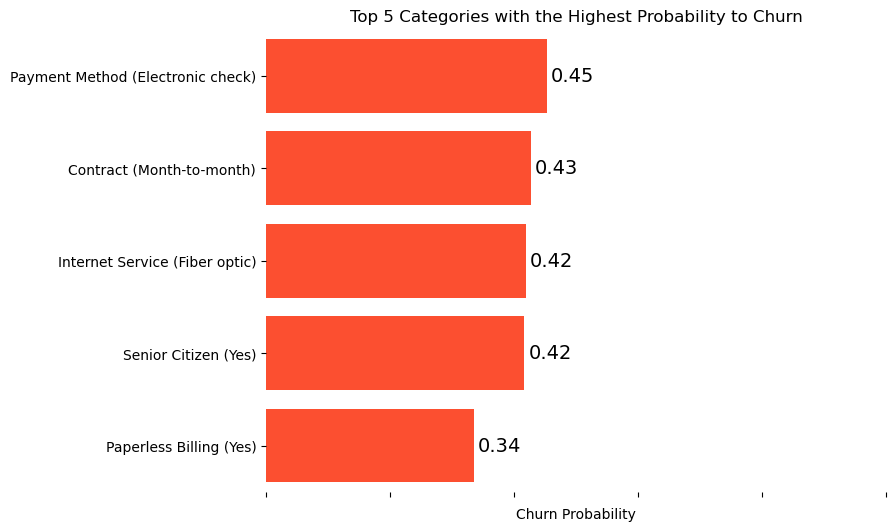

In [39]:
fig, ax = plt.subplots(figsize=(8,6))

sns.barplot(
    data=attr_crosstab.iloc[:5],
    x='churn',
    y='attribute',
    color='#FC4F30',
    saturation=1,
    ax=ax
)

ax.bar_label(ax.containers[0], padding=3, fmt='%.2f', fontsize=14, fontweight='medium')
ax.grid(False, axis='y')
ax.set_title('Top 5 Categories with the Highest Probability to Churn')

ax.set_xlim(0, 1)
ax.set_ylabel('')
ax.set_xlabel('Churn Probability')

ax.set_xticklabels([])
sns.despine(left=True, bottom=True)
plt.show()


#### 2.3.3.2. Top 5 categorical value with highest retain rate

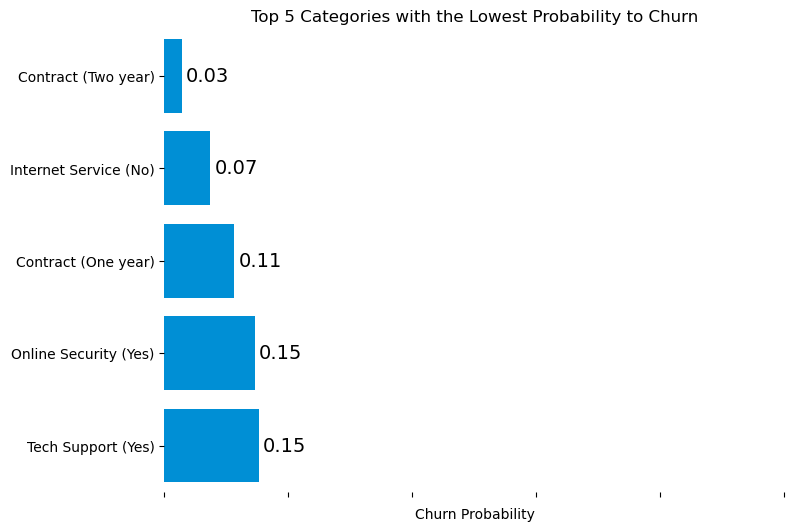

In [40]:
fig, ax = plt.subplots(figsize=(8,6))

sns.barplot(
    data=attr_crosstab.iloc[-5:].sort_values('churn'),
    x='churn',
    y='attribute',
    color='#008FD5',
    saturation=1,
    ax=ax
)

ax.bar_label(ax.containers[0], padding=3, fmt='%.2f', fontsize=14, fontweight='medium')
ax.grid(False, axis='y')
ax.set_title('Top 5 Categories with the Lowest Probability to Churn')

ax.set_xlim(0, 1)
ax.set_ylabel('')
ax.set_xlabel('Churn Probability')

ax.set_xticklabels([])
sns.despine(left=True, bottom=True)
plt.show()


### 2.3.4. Numerical features vs. label

#### 2.3.4.1. Tenure (tuổi hợp đồng)

- Tenure có mối tương quan âm với khả năng rời bỏ của khách hàng

In [41]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def plot_churn_kde_with_percentiles(df, column, hue_col, percentiles=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.grid(False, axis='x')

    # Biểu đồ KDE
    sns.kdeplot(
        data=df,
        x=column,
        hue=hue_col,
        multiple='fill',
        linewidth=3,
        ax=ax,
        alpha=0.9
    )

    if percentiles is not None:
        # Lọc theo churn để lấy 2 tập churn và retain
        tenure_churn = df[df[hue_col] == 'retain'][column]
        tenure_retain = df[df[hue_col] == 'churn'][column]

        # Dùng KDE để ước lượng phân phối
        kde_churn = gaussian_kde(tenure_churn)
        kde_retain = gaussian_kde(tenure_retain)

        # Màu sắc cho các phân vị
        colors = sns.color_palette("husl", len(percentiles))

        # Duyệt qua các phân vị và vẽ các đường tương ứng
        for idx, p in enumerate(percentiles):
            perc_val = np.percentile(df[column], p)
            pdf_churn = kde_churn(perc_val)[0]
            pdf_retain = kde_retain(perc_val)[0]
            total = pdf_churn + pdf_retain
            prob_churn = pdf_churn / total if total > 0 else 0

            # Vẽ đường phân vị
            ax.axvline(perc_val, color=colors[idx], linestyle='--', linewidth=2, alpha=0.9)
            ax.text(perc_val + 1, 0.95 - 0.05 * idx,
                    f'{p}th:\n{perc_val:.0f} mo',
                    color=colors[idx], fontsize=11)
            ax.plot(perc_val, prob_churn, 'o', color='purple', markersize=10)
            ax.text(perc_val + 1, prob_churn + 0.03,
                    f'{prob_churn:.1%}',
                    color='purple', fontsize=11)

    # Hoàn thiện biểu đồ
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), title='', ncol=2, frameon=False)
    ax.set_xticks(np.arange(0, df[column].max(), 10))
    ax.set_xlim(df[column].min(), df[column].max())
    ax.set_yticks(np.linspace(0, 1, 5))
    ax.set_ylabel('Probability')
    sns.despine(left=True, bottom=True)
    plt.show()



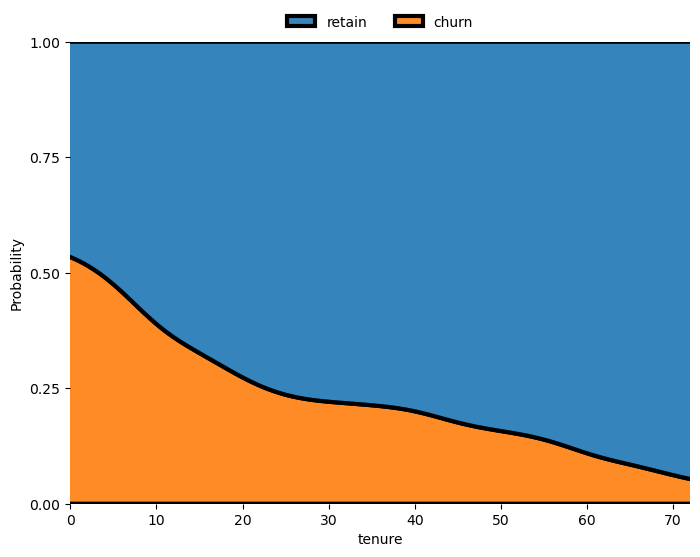

In [42]:
# Cách sử dụng không có phân vị
plot_churn_kde_with_percentiles(df_viz, column='tenure', hue_col='churn')
#  percentiles=[10, 20, 30]

##### Tenure vs. Contract

- Biểu đồ cho thấy khách hàng mới (tenure thấp) có xu hướng chọn hợp đồng theo tháng (Month_to_Month)

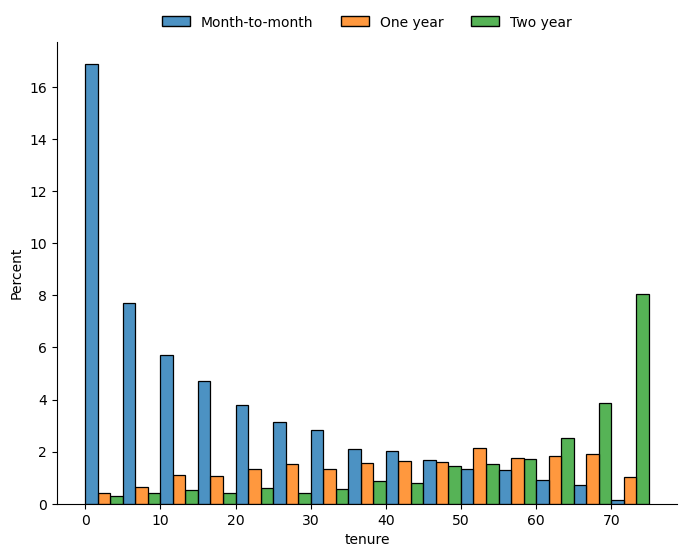

In [43]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(data=df_viz, x='tenure', hue='contract', stat='percent', multiple='dodge', ax=ax, binwidth=5, alpha=0.8)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, 1), ncol=3, title='', frameon=False)

sns.despine()
plt.show()

#### 2.3.4.2. monthly_charges

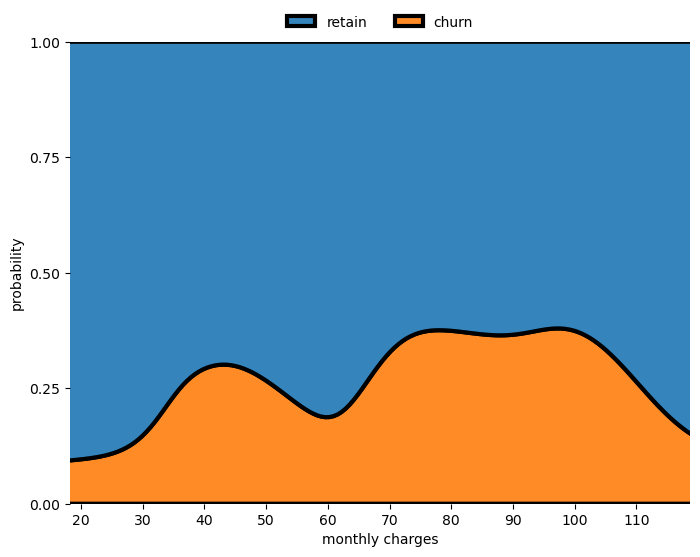

In [44]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid(False, axis='x')
sns.kdeplot(data=df_viz, x='monthly_charges', hue='churn', multiple='fill', linewidth=3, ax=ax, alpha=0.9)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, 1), title='', ncol=2, frameon=False)

ax.set_xticks(np.arange(0,df_viz['monthly_charges'].max(),10))
ax.set_xlim(df_viz['monthly_charges'].min(),df_viz['monthly_charges'].max())

ax.set_yticks(np.linspace(0,1,5))
ax.set_ylabel('probability')
ax.set_xlabel('monthly charges')

sns.despine(left=True, bottom=True)

# ax.axis('tight')
plt.show()

- xu hướng không rõ ràng
- monthly_charge tùy vào nhu cầu sử dụng dịch vụ của khách hàng.
- có thể ưu tiên lưu ý khách hàng có mức phí cao.

##### vs. service
internet_service và phone_service

In [45]:
distinct_pairs = df[['phone_service', 'internet_service']].drop_duplicates()
print(distinct_pairs)

   phone_service internet_service
0             No              DSL
1            Yes              DSL
4            Yes      Fiber optic
11           Yes               No


- khách hàng sử dụng 1 trong 2 hoặc cả 2 loại dịch vụ chính: phone_service và internet_service

c:\Users\HP\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\HP\AppData\Local\Temp\ipykernel_6140\944040244.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


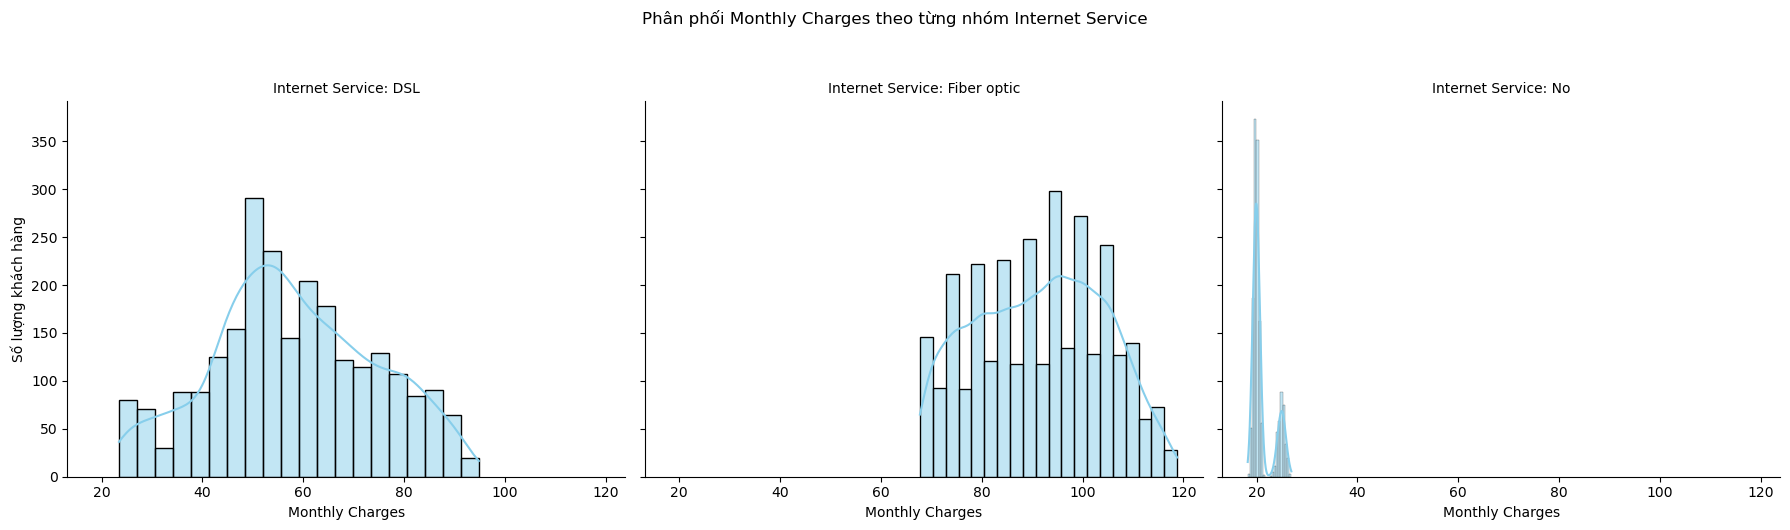

In [46]:
g = sns.FacetGrid(df_viz, col='internet_service', height=5, aspect=1.2)
g.map(sns.histplot, 'monthly_charges', kde=True, bins=20, color='skyblue')

g.set_titles('Internet Service: {col_name}')
g.set_axis_labels('Monthly Charges', 'Số lượng khách hàng')
plt.suptitle('Phân phối Monthly Charges theo từng nhóm Internet Service', y=1.05)
plt.tight_layout()
plt.show()

- khách hàng sử dụng internet_service loại fiber optic thường trả phí cao.

### new feature: amt_service_used

- amt_service_used: số lượng dịch vụ kèm theo internet_service mà khách hàng sử dụng
- càng nhiều dịch vụ, monthly_charges càng cao.
- tenure và amt_service_used cũng có tương quan dương. Khi khách hàng dùng càng lâu thì độ tin cậy về chất lượng dịch vụ cũng cao nên xu hướng sử dụng nhiều loại dịch vụ hơn.


In [47]:
df_new = df.copy()
service_cols = [
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies'
]
df_new['amt_service_used'] = df_new[service_cols].apply(lambda row: sum(row == 'Yes'), axis=1)


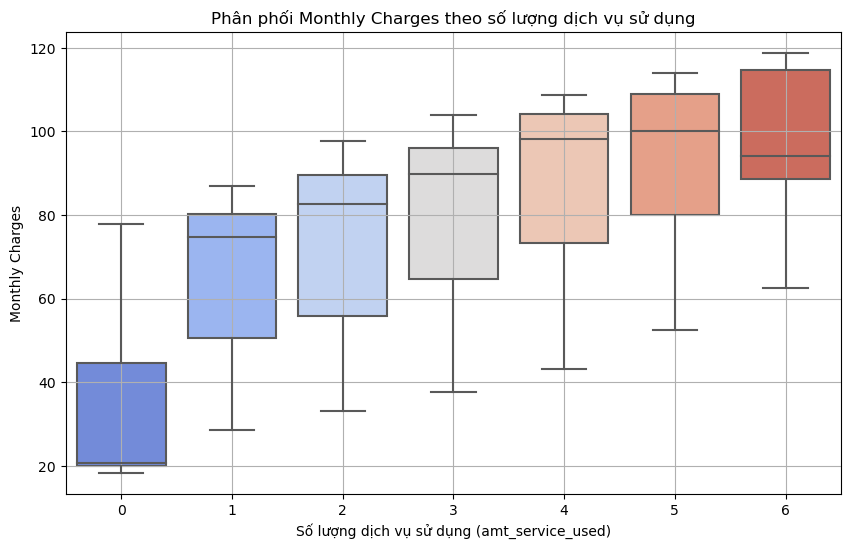

In [48]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_new, x='amt_service_used', y='monthly_charges', palette='coolwarm')
plt.title('Phân phối Monthly Charges theo số lượng dịch vụ sử dụng')
plt.xlabel('Số lượng dịch vụ sử dụng (amt_service_used)')
plt.ylabel('Monthly Charges')
plt.grid(True)
plt.show()


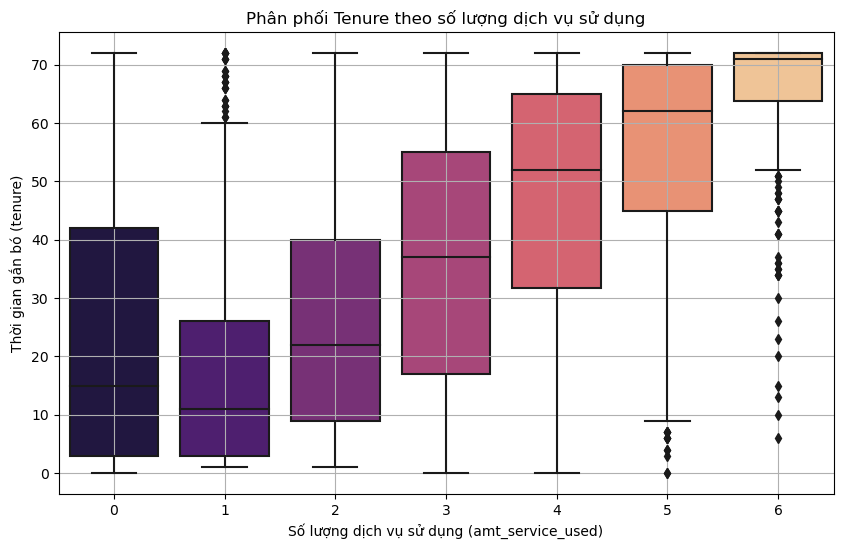

In [49]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_new, x='amt_service_used', y='tenure', palette='magma')
plt.title('Phân phối Tenure theo số lượng dịch vụ sử dụng')
plt.xlabel('Số lượng dịch vụ sử dụng (amt_service_used)')
plt.ylabel('Thời gian gắn bó (tenure)')
plt.grid(True)
plt.show()


# 3. Data Preprocessing

## import libraries

In [56]:
# encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

# scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# oversampling
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import ADASYN

# train test split
from sklearn.model_selection import train_test_split

# model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer

# model evaluation & tuning hyperparameter
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import SelectKBest, RFE, SelectFromModel
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

# # explainable AI
# import shap

## 3.1. Train - Test split

In [57]:
data_X = df.drop('churn', axis=1)
data_y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.3,
                                                    random_state=1, stratify=data_y)

## 3.2. Label Encoding

In [58]:
le = LabelEncoder()

le.fit(y_train)

y_train_encode = le.transform(y_train)
y_test_encode = le.transform(y_test)

In [59]:
le.classes_

array(['No', 'Yes'], dtype=object)

## 3.3. One Hot Encoding

In [60]:
ohe = OneHotEncoder(sparse_output=False, drop='if_binary')

ohe.fit(X_train[column_categorical])

X_train_ohe = ohe.transform(X_train[column_categorical])
X_test_ohe = ohe.transform(X_test[column_categorical])

In [61]:
X_train_ohe

array([[1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.]])

## 3.4. Encoded Dataframe

In [62]:
column_ohe = ohe.get_feature_names_out()
column_ohe

array(['gender_Male', 'senior_citizen_Yes', 'partner_Yes',
       'dependents_Yes', 'phone_service_Yes', 'multiple_lines_Yes',
       'internet_service_DSL', 'internet_service_Fiber optic',
       'internet_service_No', 'online_security_Yes', 'online_backup_Yes',
       'device_protection_Yes', 'tech_support_Yes', 'streaming_tv_Yes',
       'streaming_movies_Yes', 'contract_Month-to-month',
       'contract_One year', 'contract_Two year', 'paperless_billing_Yes',
       'payment_method_Bank transfer (automatic)',
       'payment_method_Credit card (automatic)',
       'payment_method_Electronic check', 'payment_method_Mailed check'],
      dtype=object)

In [63]:
for i, col in enumerate(column_ohe):
  column_ohe[i] = inflection.underscore(column_ohe[i]).replace(' ', '_').replace('_(automatic)','')

column_ohe

array(['gender_male', 'senior_citizen_yes', 'partner_yes',
       'dependents_yes', 'phone_service_yes', 'multiple_lines_yes',
       'internet_service_dsl', 'internet_service_fiber_optic',
       'internet_service_no', 'online_security_yes', 'online_backup_yes',
       'device_protection_yes', 'tech_support_yes', 'streaming_tv_yes',
       'streaming_movies_yes', 'contract_month_to_month',
       'contract_one_year', 'contract_two_year', 'paperless_billing_yes',
       'payment_method_bank_transfer', 'payment_method_credit_card',
       'payment_method_electronic_check', 'payment_method_mailed_check'],
      dtype=object)

### 3.4.1 Train set

In [64]:
X_train.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges
6427,Male,No,No,No,41,Yes,No,No,No,No,No,No,No,No,Two year,No,Mailed check,20.15,802.35
6971,Female,Yes,Yes,No,18,Yes,Yes,Fiber optic,No,No,No,Yes,Yes,Yes,Month-to-month,No,Bank transfer (automatic),99.75,1836.25
96,Male,No,Yes,Yes,71,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,One year,Yes,Credit card (automatic),66.85,4748.70
5640,Male,No,No,No,1,Yes,No,Fiber optic,No,No,No,No,No,Yes,Month-to-month,No,Electronic check,79.60,79.60
414,Female,Yes,Yes,No,48,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),70.65,3545.05


In [65]:
# create dataframe from one-hot encoded features
X_train_ohe_df = pd.DataFrame(X_train_ohe, columns=column_ohe, index=X_train.index)

# combine the numerical and encoded features
X_train_encode = pd.concat([X_train.drop(columns=column_categorical), X_train_ohe_df], axis=1)
X_train_encode.head()

,tenure,monthly_charges,total_charges,gender_male,senior_citizen_yes,partner_yes,dependents_yes,phone_service_yes,multiple_lines_yes,internet_service_dsl,...,streaming_tv_yes,streaming_movies_yes,contract_month_to_month,contract_one_year,contract_two_year,paperless_billing_yes,payment_method_bank_transfer,payment_method_credit_card,payment_method_electronic_check,payment_method_mailed_check
6427,41,20.15,802.35,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
6971,18,99.75,1836.25,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
96,71,66.85,4748.70,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
5640,1,79.60,79.60,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
414,48,70.65,3545.05,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


### 3.4.2 Test set

In [66]:
# create dataframe from one-hot encoded features
X_test_ohe_df = pd.DataFrame(X_test_ohe, columns=column_ohe, index=X_test.index)

# combine the numerical and encoded features
X_test_encode = pd.concat([X_test.drop(columns=column_categorical), X_test_ohe_df], axis=1)
X_test_encode.head()

,tenure,monthly_charges,total_charges,gender_male,senior_citizen_yes,partner_yes,dependents_yes,phone_service_yes,multiple_lines_yes,internet_service_dsl,...,streaming_tv_yes,streaming_movies_yes,contract_month_to_month,contract_one_year,contract_two_year,paperless_billing_yes,payment_method_bank_transfer,payment_method_credit_card,payment_method_electronic_check,payment_method_mailed_check
1630,38,102.60,4009.20,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2008,4,87.10,341.45,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2685,72,100.65,7334.05,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
903,56,105.60,6068.65,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3905,3,35.20,108.95,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### 3.4.3 final encoded dataframe

In [67]:
# combine the X-train and X-test
data_encode = pd.concat([X_train_encode, X_test_encode], axis=0)

# merge y-train và y-test vào tập dữ liệu encode
data_encode = data_encode.join(pd.Series(y_train_encode, name='churn', index=X_train_encode.index), lsuffix='_1', rsuffix='_2')
data_encode = data_encode.join(pd.Series(y_test_encode, name='churn', index=X_test_encode.index), lsuffix='_1', rsuffix='_2')

data_encode['churn_1'] = data_encode['churn_1'].fillna(data_encode['churn_2'])
data_encode.drop(columns='churn_2', inplace=True)
data_encode.rename(columns={'churn_1': 'churn'}, inplace=True)


data_encode.head()

,tenure,monthly_charges,total_charges,gender_male,senior_citizen_yes,partner_yes,dependents_yes,phone_service_yes,multiple_lines_yes,internet_service_dsl,...,streaming_movies_yes,contract_month_to_month,contract_one_year,contract_two_year,paperless_billing_yes,payment_method_bank_transfer,payment_method_credit_card,payment_method_electronic_check,payment_method_mailed_check,churn
6427,41,20.15,802.35,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
6971,18,99.75,1836.25,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
96,71,66.85,4748.70,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
5640,1,79.60,79.60,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
414,48,70.65,3545.05,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


## 3.5. Feature Scaling

In [68]:
X_train_scale = X_train_encode.copy()
X_test_scale = X_test_encode.copy()

for i in column_numerical:
  scaler = MinMaxScaler()
  scaler.fit(X_train_scale[[i]])

  X_train_scale[[i]] = scaler.transform(X_train_scale[[i]])
  X_test_scale[[i]] = scaler.transform(X_test_scale[[i]])

## 3.6. Scaled Dataframe

In [69]:
# Combine X-train và X-test
data_scale = pd.concat([X_train_scale, X_test_scale], axis=0)

# Join với y_train
data_scale = data_scale.join(
    pd.Series(y_train_encode, name='churn', index=X_train_scale.index),
    lsuffix='_1', rsuffix='_2'
)

# Join với y_test
data_scale = data_scale.join(
    pd.Series(y_test_encode, name='churn', index=X_test_scale.index),
    lsuffix='_1', rsuffix='_2'
)

# Gộp 2 cột churn (ưu tiên churn_1, nếu NaN thì lấy churn_2)
data_scale['churn_1'] = data_scale['churn_1'].fillna(data_scale['churn_2'])

# Xóa churn_2 và đổi tên churn_1 về 'churn'
data_scale = data_scale.drop(columns='churn_2')
data_scale = data_scale.rename(columns={'churn_1': 'churn'})

# Hiển thị 5 dòng đầu
data_scale.head()


,tenure,monthly_charges,total_charges,gender_male,senior_citizen_yes,partner_yes,dependents_yes,phone_service_yes,multiple_lines_yes,internet_service_dsl,...,streaming_movies_yes,contract_month_to_month,contract_one_year,contract_two_year,paperless_billing_yes,payment_method_bank_transfer,payment_method_credit_card,payment_method_electronic_check,payment_method_mailed_check,churn
6427,0.569444,0.017439,0.092386,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
6971,0.250000,0.810663,0.211433,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
96,0.986111,0.482810,0.546783,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
5640,0.013889,0.609865,0.009165,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
414,0.666667,0.520678,0.408190,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [70]:
data_scale_train = pd.concat([X_train_scale, pd.Series(y_train_encode, name='churn', index=X_train_scale.index)], axis=1)
data_scale_train.head()

,tenure,monthly_charges,total_charges,gender_male,senior_citizen_yes,partner_yes,dependents_yes,phone_service_yes,multiple_lines_yes,internet_service_dsl,...,streaming_movies_yes,contract_month_to_month,contract_one_year,contract_two_year,paperless_billing_yes,payment_method_bank_transfer,payment_method_credit_card,payment_method_electronic_check,payment_method_mailed_check,churn
6427,0.569444,0.017439,0.092386,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
6971,0.250000,0.810663,0.211433,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
96,0.986111,0.482810,0.546783,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0
5640,0.013889,0.609865,0.009165,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
414,0.666667,0.520678,0.408190,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0


## 3.7. Correlation

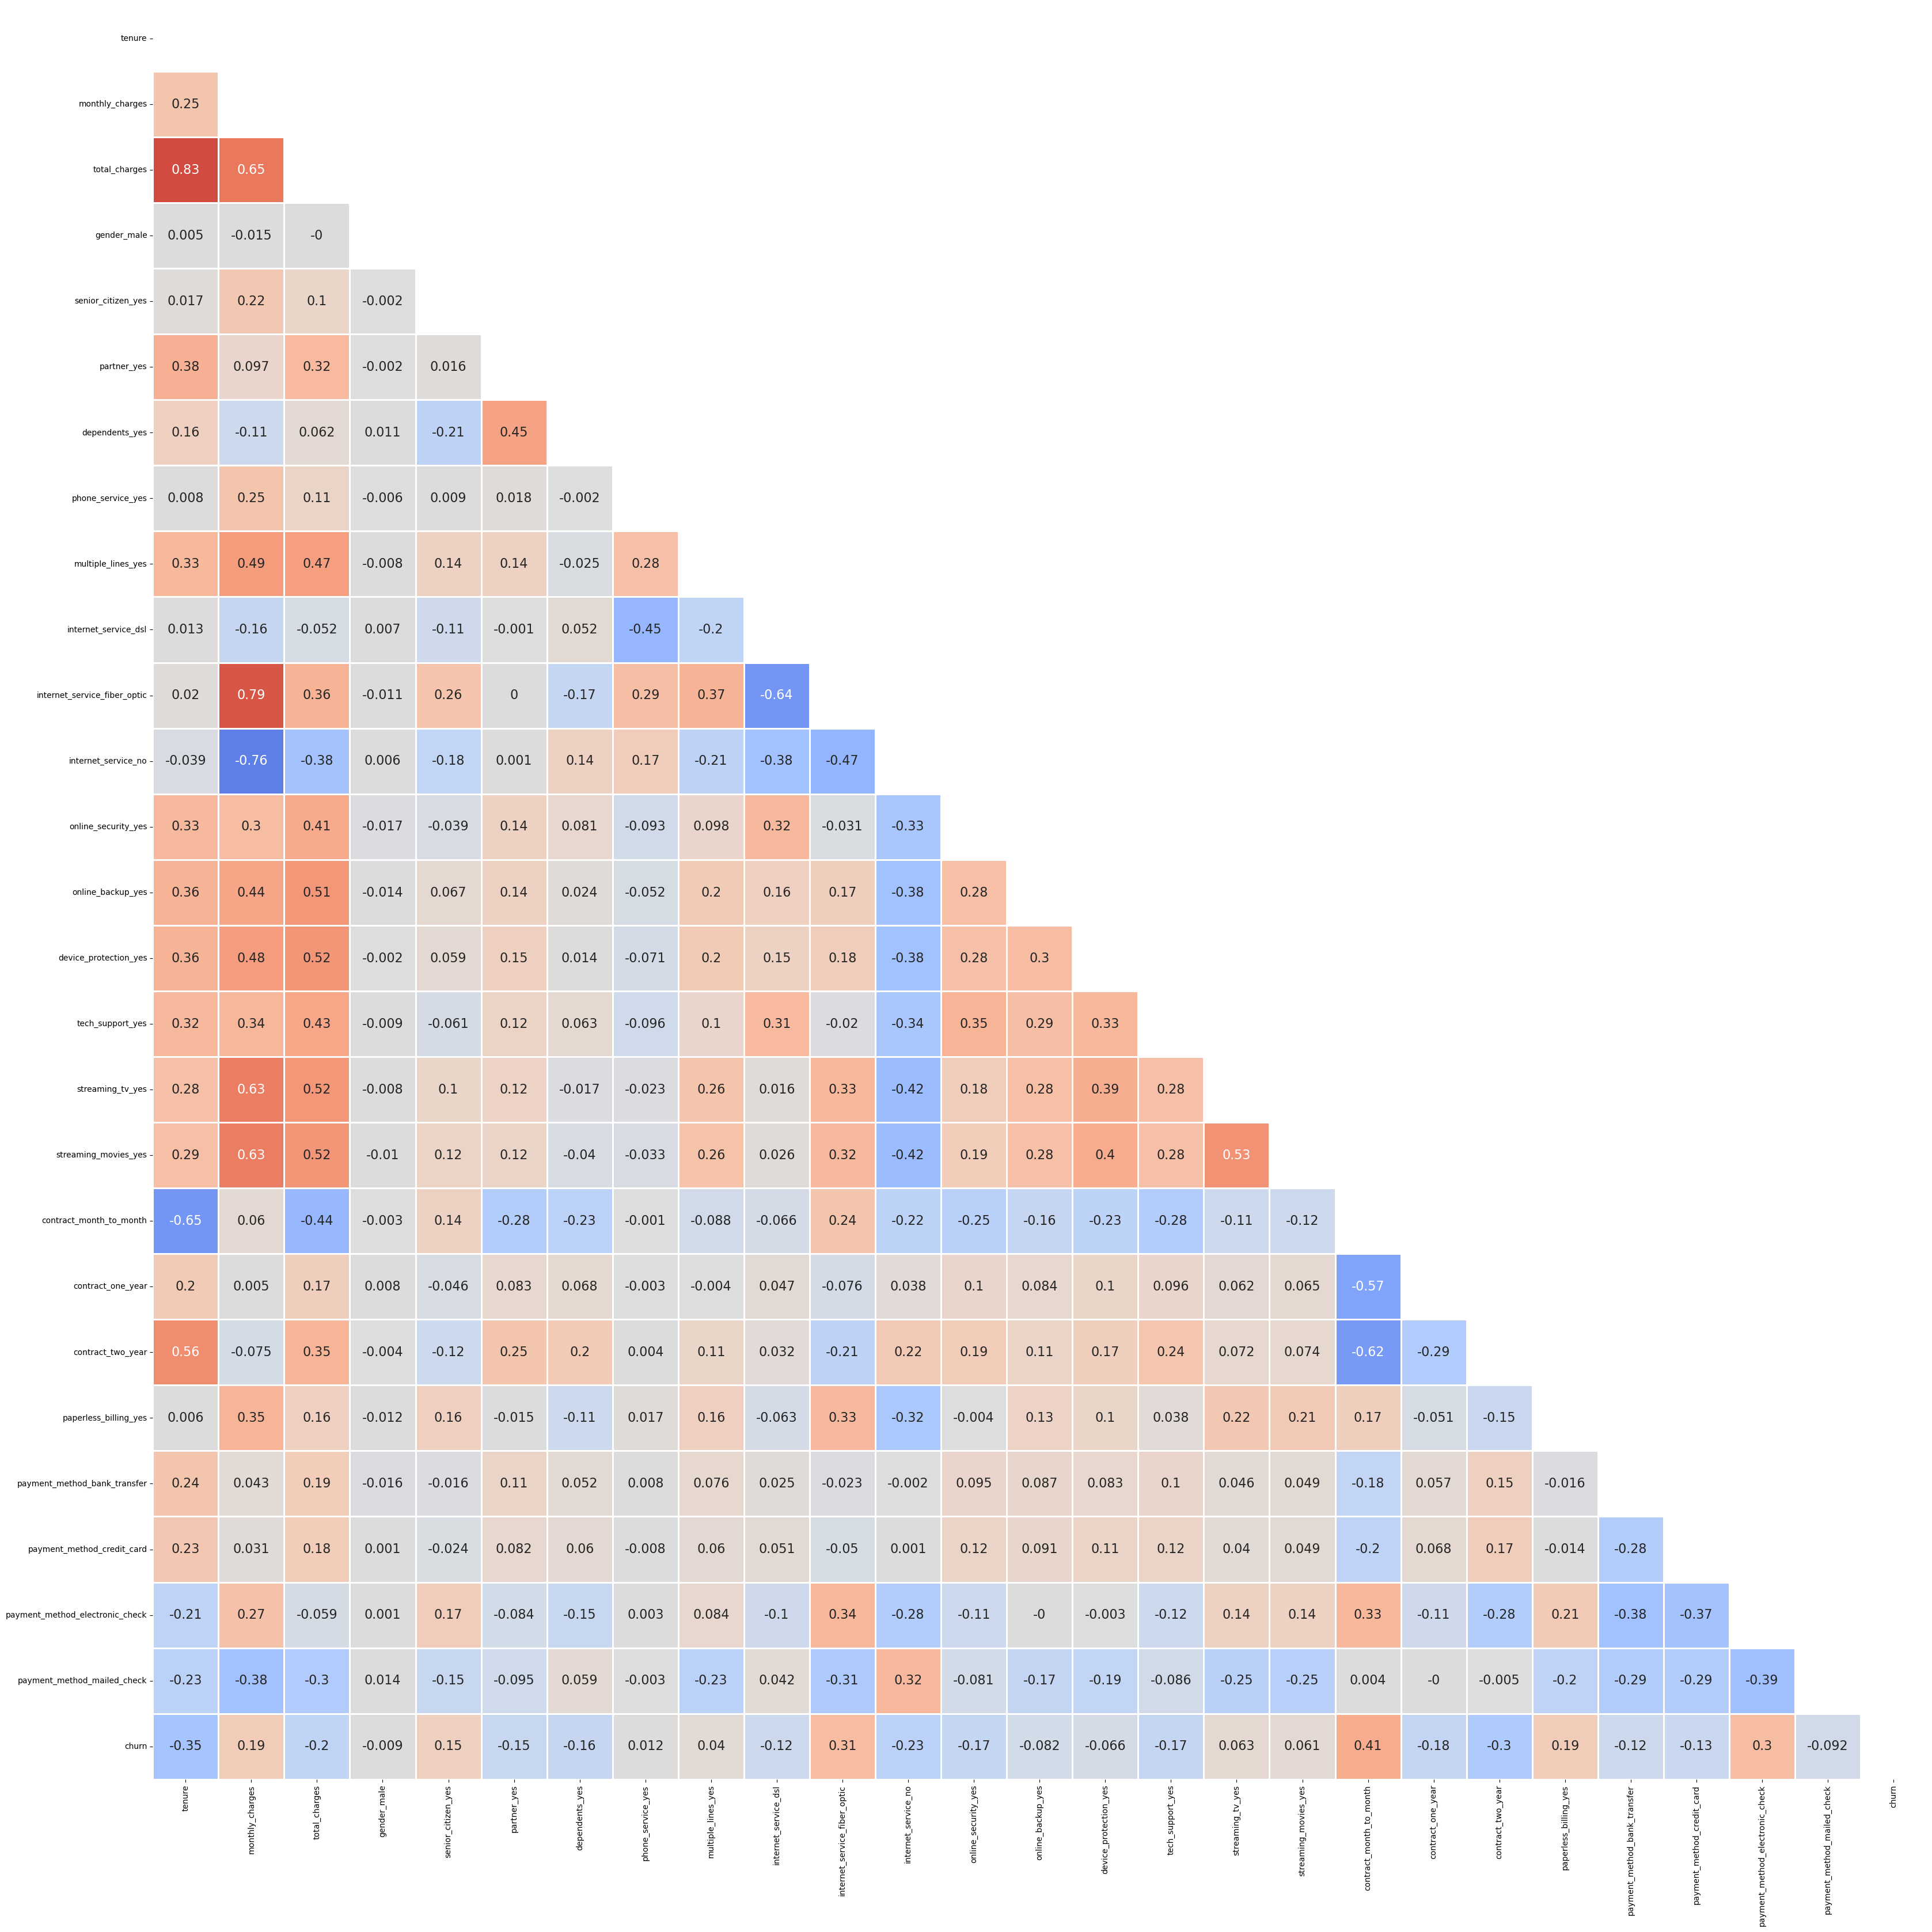

In [71]:
corr_matrix = data_scale.corr().round(3)

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(40,40))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, cbar=False,
            cmap='coolwarm', linewidth=1, mask=mask,
            square=True, annot=True, annot_kws={'fontsize':16}, ax=ax)

plt.show()

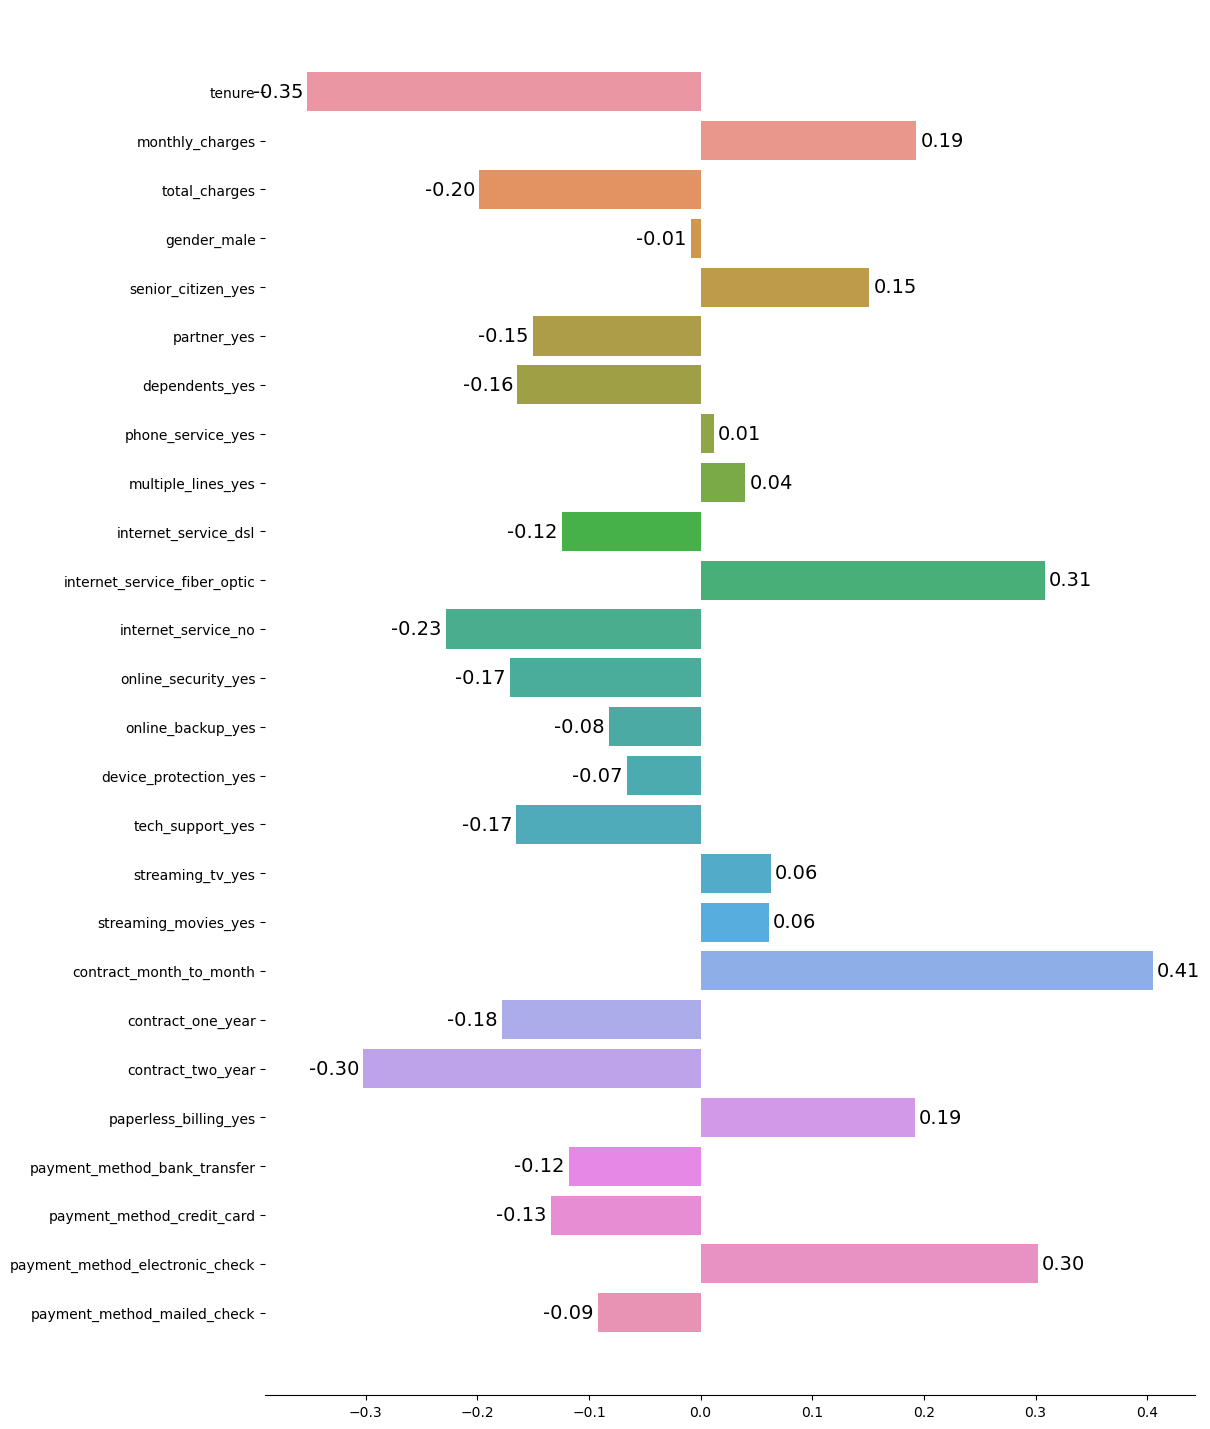

In [72]:
corr_matrix = data_scale.corr().round(3)
corr_target = corr_matrix['churn'].drop('churn')

fig, ax = plt.subplots(figsize=(12,18))

sns.barplot(x=corr_target.values, y=corr_target.index, ax=ax)
ax.bar_label(ax.containers[0], padding=3, fmt='%.2f', fontsize=14, fontweight='medium')

ax.axis('tight')
sns.despine(left=True)
plt.show()

### 3.7.1. positive correlation

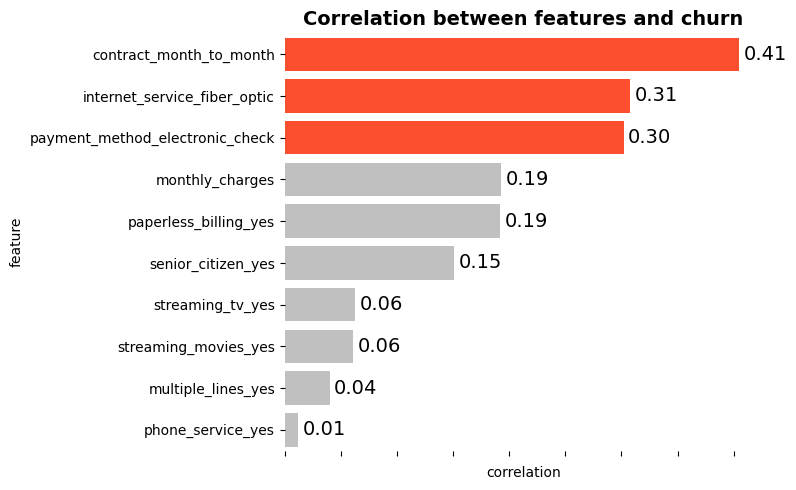

In [73]:
# Tính toán tương quan
corr_matrix = data_scale.corr().round(3)
corr_target = corr_matrix['churn'].drop('churn').sort_values(ascending=False)
corr_positive = corr_target[corr_target >= 0]

# Tạo DataFrame để ánh xạ màu
df_corr = corr_positive.reset_index()
df_corr.columns = ['feature', 'correlation']
df_corr['highlight'] = ['Top' if i < 3 else 'Other' for i in range(len(df_corr))]

# Tạo bảng màu ánh xạ với hue
palette = {'Top': '#FC4F30', 'Other': 'silver'}

# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(
    data=df_corr,
    x='correlation',
    y='feature',
    hue='highlight',
    dodge=False,
    palette=palette,
    saturation=1,
    ax=ax
)

# Thêm nhãn và chỉnh sửa
for container in ax.containers:
    ax.bar_label(container, padding=3, fmt='%.2f', fontsize=14, fontweight='medium')
ax.set_xticklabels([])
sns.despine(left=True, bottom=True)
ax.legend_.remove()  # Ẩn chú thích nếu không cần
plt.title('Correlation between features and churn', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### 3.7.2. negative correlation

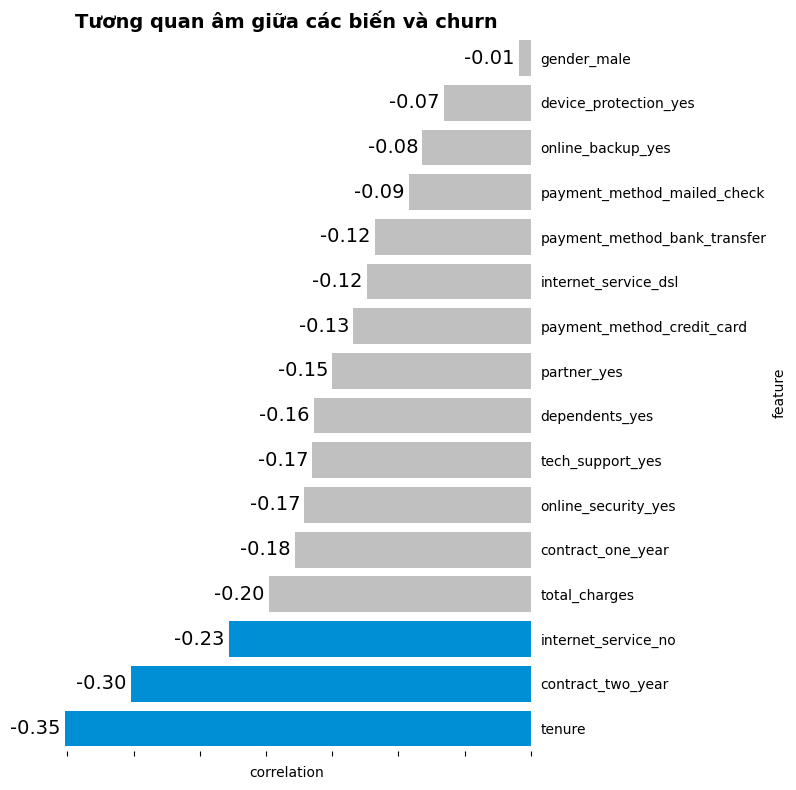

In [74]:
# Lấy các biến có tương quan âm
corr_negative = corr_target[corr_target < 0]

# Xác định top 3 tương quan âm mạnh nhất
threshold_top = 3
threshold_bot = corr_negative.size - threshold_top - 1

# Tạo DataFrame để dùng hue
df_corr_neg = corr_negative.reset_index()
df_corr_neg.columns = ['feature', 'correlation']
df_corr_neg['highlight'] = [
    'Top' if i > threshold_bot else 'Other'
    for i in range(len(df_corr_neg))
]

# Đặt màu theo nhóm
palette = {'Top': '#008FD5', 'Other': 'silver'}

# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(8, 8))
sns.barplot(
    data=df_corr_neg,
    x='correlation',
    y='feature',
    hue='highlight',
    dodge=False,
    palette=palette,
    saturation=1,
    ax=ax
)

# Gắn nhãn cho tất cả bar
for container in ax.containers:
    ax.bar_label(container, padding=3, fmt='%.2f', fontsize=14, fontweight='medium')


# Các tùy chỉnh trục
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_xticklabels([])

# Làm sạch biểu đồ
sns.despine(left=True, bottom=True)
ax.legend_.remove()  # Tắt chú thích
plt.tick_params(right=False)
plt.title('Tương quan âm giữa các biến và churn', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## 3.8. Oversampling with SMOTE

In [75]:
# numerical
column_numerical = ['tenure', 'monthly_charges', 'total_charges']

# categorical
column_categorical = list(data_scale.columns)
column_categorical.remove('tenure')
column_categorical.remove('monthly_charges')
column_categorical.remove('total_charges')

In [76]:
# print(type(X_train_scale))
# print(type(y_train_encode))
print(y_train_encode[:10])
print(set(y_train_encode))


[0 1 0 1 0 0 0 0 0 0]
{0, 1}


In [77]:
# from imblearn.over_sampling import RandomOverSampler

# # Sử dụng RandomOverSampler
# ros = RandomOverSampler(random_state=1)
# X_train_smote, y_train_smote = ros.fit_resample(X_train_scale, y_train_encode)

# # Chuyển lại thành DataFrame
# X_train_smote_df = pd.DataFrame(X_train_smote, columns=X_train_scale.columns)
# y_train_smote_df = pd.DataFrame(y_train_smote, columns=['churn'])

# # Kết hợp lại
# data_smote = pd.concat([X_train_smote_df, y_train_smote_df], axis=1)


In [78]:
smote = SMOTE(random_state=1)

X_train_smote, y_train_smote = smote.fit_resample(X_train_scale, y_train_encode)

X_train_smote_df = pd.DataFrame(X_train_smote, columns=X_train_scale.columns)
y_train_smote_df = pd.DataFrame(y_train_smote, columns=['churn'])

data_smote = pd.concat([X_train_smote_df, y_train_smote_df], axis=1)

In [73]:
data_scale_train['churn'].value_counts()

churn
0    3622
1    1308
Name: count, dtype: int64

In [74]:
data_smote['churn'].value_counts()

churn
0    3622
1    3622
Name: count, dtype: int64

In [75]:
data_smote = data_smote.reset_index(drop=True)

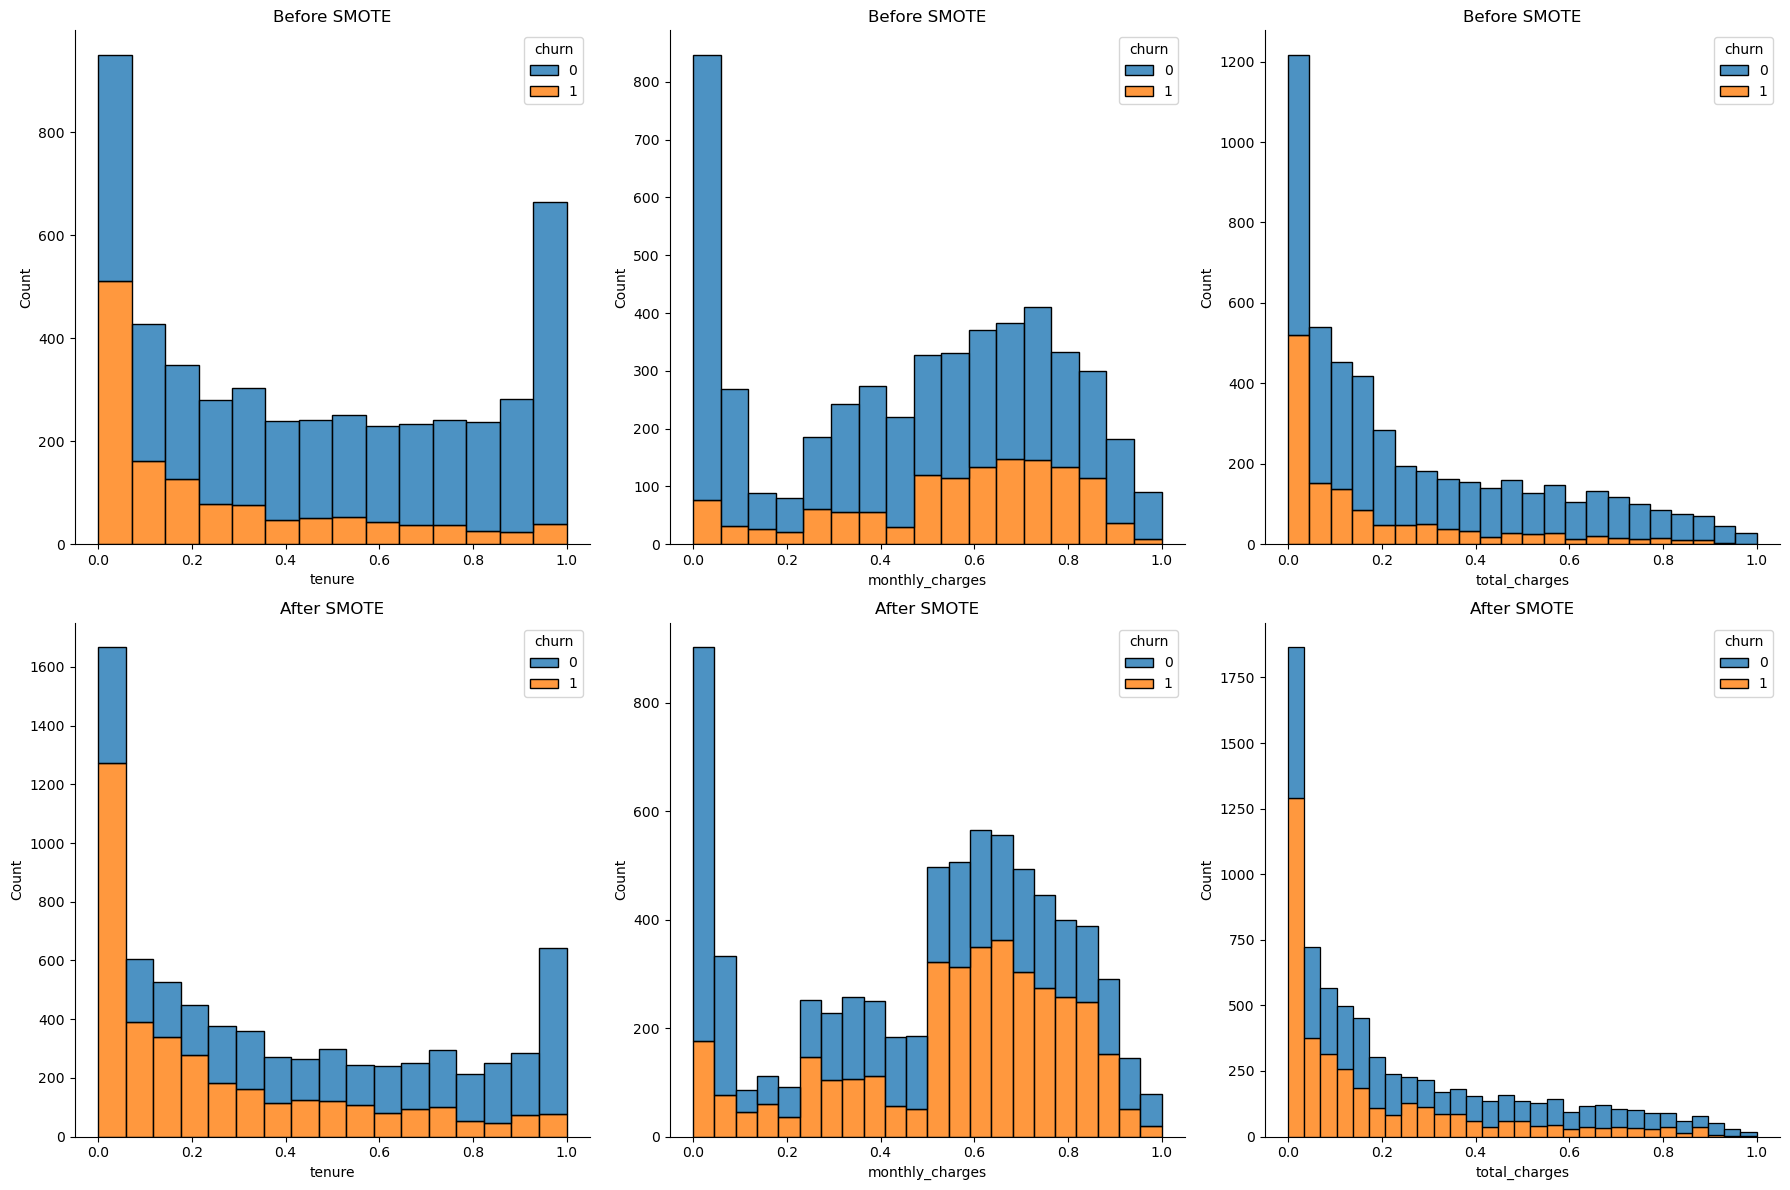

In [76]:
fig, ax = plt.subplots(2, 3, figsize=(18,12))
axes_list = [axes for axes_row in ax for axes in axes_row]

for i, col in enumerate(column_numerical):
  sns.histplot(data=data_scale_train, x=col, hue='churn', multiple='stack', ax=axes_list[i], alpha=0.8)
  axes_list[i].set_title('Before SMOTE')

for i, col in enumerate(column_numerical):
  sns.histplot(data=data_smote, x=col, hue='churn', multiple='stack', ax=axes_list[i+3], alpha=0.8)
  axes_list[i+3].set_title('After SMOTE')

plt.tight_layout()
sns.despine()

plt.show()

# 4. Model - CLASSIFICATION

## 4.1. evaluation score function

In [77]:
def get_score(y_pred_list, y_test, average=None, plot=True, axis=0, cmap='Blues'):
  model_name = []
  accuracy = []
  precision = []
  recall = []
  f1 = []
  roc_auc = []

  for name, y_pred in y_pred_list.items():
    model_name.append(name)
    if average != None:
      accuracy.append(accuracy_score(y_test, y_pred))
      precision.append(precision_score(y_test, y_pred, average=average))
      recall.append(recall_score(y_test, y_pred, average=average))
      f1.append(f1_score(y_test, y_pred, average=average))
      roc_auc.append(roc_auc_score(y_test, y_pred, average=average))

      score_list = {
        'model':model_name,
        'accuracy':accuracy,
        f'{average}_avg_precision':precision,
        f'{average}_avg_recall':recall,
        f'{average}_avg_f1_score':f1,
        'roc_auc':roc_auc
      }
    else:
      accuracy.append(accuracy_score(y_test, y_pred))
      precision.append(precision_score(y_test, y_pred))
      recall.append(recall_score(y_test, y_pred))
      f1.append(f1_score(y_test, y_pred))
      roc_auc.append(roc_auc_score(y_test, y_pred))

      score_list = {
        'model':model_name,
        'accuracy':accuracy,
        'precision':precision,
        'recall':recall,
        'f1_score':f1,
        'roc_auc':roc_auc
      }

  score_df = pd.DataFrame(score_list).set_index('model')

  if plot:
    display(score_df.style.background_gradient(axis=axis, cmap=cmap))

  return score_df

## 4.2. default parameter

In [78]:
X_train_model = X_train_smote.copy()
y_train_model = y_train_smote.copy()

X_test_model = X_test_scale.copy()
y_test_model = y_test_encode.copy()

In [79]:
model_list = {
    'Logistic Regression':LogisticRegression(max_iter=1000, random_state=1),
    'Ridge Classifier':RidgeClassifier(random_state=1),
    # 'KNN':KNeighborsClassifier(),
    'SVC':SVC(random_state=1),
    'Neural Network':MLPClassifier(max_iter=1000, random_state=1),
    'Decision Tree':DecisionTreeClassifier(random_state=1),
    'Random Forest':RandomForestClassifier(random_state=1),
    'Gradient Boosting Classifier':GradientBoostingClassifier(random_state=1),
    'AdaBoost Classifier':AdaBoostClassifier(random_state=1),
    'CatBoost Classifier':CatBoostClassifier(random_state=1, verbose=False),
    'Hist Gradient Boosting':HistGradientBoostingClassifier(random_state=1),
    'XGBoost':XGBClassifier(random_state=1, eval_metric='logloss'),
    'LightGBM':LGBMClassifier(random_state=1),
}



## 4.3. prediction

In [80]:
print(type(X_test_model))  

<class 'pandas.core.frame.DataFrame'>


In [81]:
y_pred_list = dict()

for name, model in model_list.items():
  model.fit(X_train_model, y_train_model)
  y_pred_list[name] = model.predict(X_test_model)

score_smote = get_score(y_pred_list, y_test_model, average='macro')

[LightGBM] [Info] Number of positive: 3622, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 629
[LightGBM] [Info] Number of data points in the train set: 7244, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,accuracy,macro_avg_precision,macro_avg_recall,macro_avg_f1_score,roc_auc
model,,,,,
Logistic Regression,0.743493,0.705055,0.752542,0.711361,0.752542
Ridge Classifier,0.743019,0.705627,0.753927,0.711542,0.753927
SVC,0.737814,0.697624,0.742416,0.703911,0.742416
Neural Network,0.720776,0.676389,0.714314,0.682102,0.714314
Decision Tree,0.734974,0.662310,0.665930,0.664025,0.665930
Random Forest,0.778041,0.715411,0.715166,0.715288,0.715166
Gradient Boosting Classifier,0.752011,0.713043,0.761755,0.720348,0.761755
AdaBoost Classifier,0.743019,0.709376,0.760756,0.713911,0.760756
CatBoost Classifier,0.768575,0.718095,0.754820,0.728709,0.754820


### 4.3.1. only Boosting methods

In [82]:
model_list = {
    'Gradient Boosting Classifier':GradientBoostingClassifier(random_state=1),
    'AdaBoost Classifier':AdaBoostClassifier(random_state=1),
    'CatBoost Classifier':CatBoostClassifier(random_state=1, verbose=False),
    'Hist Gradient Boosting':HistGradientBoostingClassifier(random_state=1),
    'XGBoost':XGBClassifier(random_state=1, eval_metric='logloss'),
    'LightGBM':LGBMClassifier(random_state=1),
}

In [83]:
y_pred_list = dict()

for name, model in model_list.items():
  model.fit(X_train_model, y_train_model)
  y_pred_list[name] = model.predict(X_test_model)

score_smote = get_score(y_pred_list, y_test_model, average='macro')

[LightGBM] [Info] Number of positive: 3622, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 629
[LightGBM] [Info] Number of data points in the train set: 7244, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,accuracy,macro_avg_precision,macro_avg_recall,macro_avg_f1_score,roc_auc
model,,,,,
Gradient Boosting Classifier,0.752011,0.713043,0.761755,0.720348,0.761755
AdaBoost Classifier,0.743019,0.709376,0.760756,0.713911,0.760756
CatBoost Classifier,0.768575,0.718095,0.754820,0.728709,0.754820
Hist Gradient Boosting,0.759110,0.708874,0.745531,0.718802,0.745531
XGBoost,0.757690,0.699352,0.722939,0.707815,0.722939
LightGBM,0.758164,0.705301,0.738058,0.715039,0.738058


## 4.4. feature selection

In [84]:
threshold = 13

filter = SelectKBest(score_func=f_classif, k=threshold)
filter.fit(X_train_model, y_train_model)

X_train_filter = filter.transform(X_train_model)
X_test_filter = filter.transform(X_test_model)

print('before filter\t:', X_train_model.shape)
print('after filter\t:', X_train_filter.shape)

before filter	: (7244, 26)
after filter	: (7244, 13)


### 4.4.1. Univariate Filter with ANOVA for feature selection

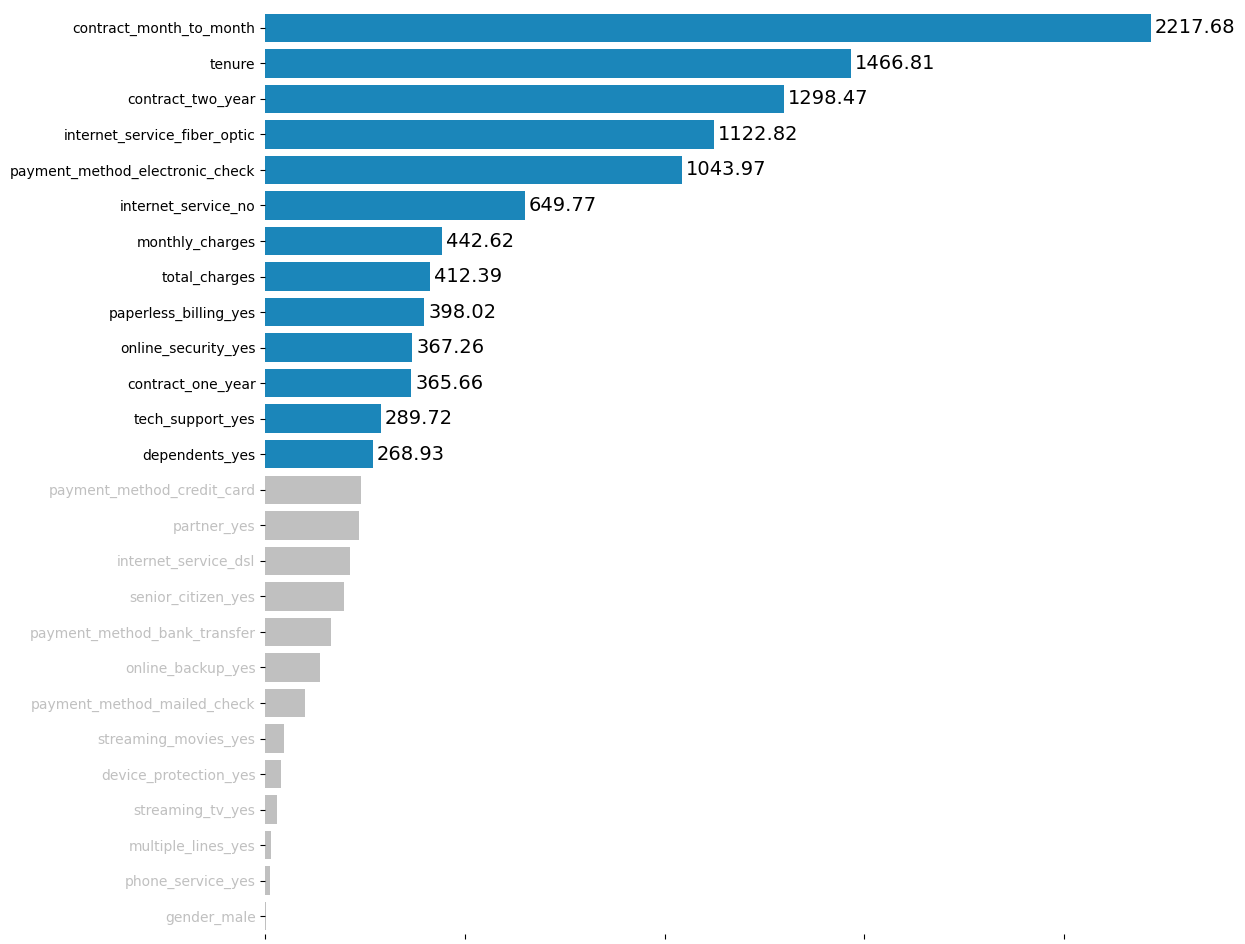

In [85]:
# viz
selected_feature = filter.get_feature_names_out()
feature_name = filter.feature_names_in_
feature_score = filter.scores_

# add to dataframe
feature_selection = pd.DataFrame({'feature_name':feature_name, 'feature_score':feature_score}).sort_values('feature_score', ascending=False)
feature_selection.reset_index(drop=True, inplace=True)

# create flag
selected = list()
for i in range(0, X_train_model.shape[1]):
  if i < threshold:
    selected.append(True)
  else:
    selected.append(False)

selected_s = pd.Series(selected, name='selected')
feature_selection = pd.concat([feature_selection, selected_s], axis=1)

# highlight the top features
palette = []
for i in range(0, len(feature_selection)):
  if i < threshold:
    palette.append('#008FD5')
  else:
    palette.append('silver')

fig, ax = plt.subplots(figsize=(12,12))

sns.barplot(data=feature_selection, x='feature_score', y='feature_name', ax=ax, palette=palette)
# ax.bar_label(ax.containers[0], padding=3, fmt='%.2f', fontsize=14, fontweight='medium')

# custom y label color
for i, label in enumerate(ax.yaxis.get_ticklabels()):
  if feature_selection.loc[i, 'selected'] == False:
    label.set_color('silver')

# custom bar label visibility
for con in ax.containers:
  # labels = [val for val in con.datavalues]
  labels = con.datavalues
  labels_len = len(labels)

  # masking the top features
  np.put(labels, np.arange(threshold,labels_len), [-1])

  # hide the labels for non-top features
  labels = [f'{val:.2f}' if val != -1 else '' for val in labels]

  ax.bar_label(con, labels=labels, padding=3, fontsize=14, fontweight='medium')

ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')

sns.despine(left=True, bottom=True)
plt.show()

In [86]:
y_pred_list = dict()

for name, model in model_list.items():
  model.fit(X_train_filter, y_train_model)
  y_pred_list[name] = model.predict(X_test_filter)

score_filter = get_score(y_pred_list, y_test_model, average='macro')

[LightGBM] [Info] Number of positive: 3622, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 603
[LightGBM] [Info] Number of data points in the train set: 7244, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,accuracy,macro_avg_precision,macro_avg_recall,macro_avg_f1_score,roc_auc
model,,,,,
Gradient Boosting Classifier,0.751065,0.712348,0.761111,0.719482,0.761111
AdaBoost Classifier,0.743966,0.709400,0.760262,0.714386,0.760262
CatBoost Classifier,0.754851,0.706566,0.745477,0.716060,0.745477
Hist Gradient Boosting,0.751065,0.703511,0.742900,0.712602,0.742900
XGBoost,0.766682,0.710688,0.737596,0.720100,0.737596
LightGBM,0.749645,0.701079,0.739088,0.710148,0.739088


### 4.4.2. Wrapper Method - Recursive Feature Elimination (RFE)

In [87]:
threshold = 13
estimator = LogisticRegression(random_state=1)

wrapper = RFE(estimator=estimator, n_features_to_select=threshold)
wrapper.fit(X_train_model, y_train_model)

X_train_wrap = wrapper.transform(X_train_model)
X_test_wrap = wrapper.transform(X_test_scale)

print('before wrapper\t:', X_train_model.shape)
print('after wrapper\t:', X_train_wrap.shape)

c:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


before wrapper	: (7244, 26)
after wrapper	: (7244, 13)


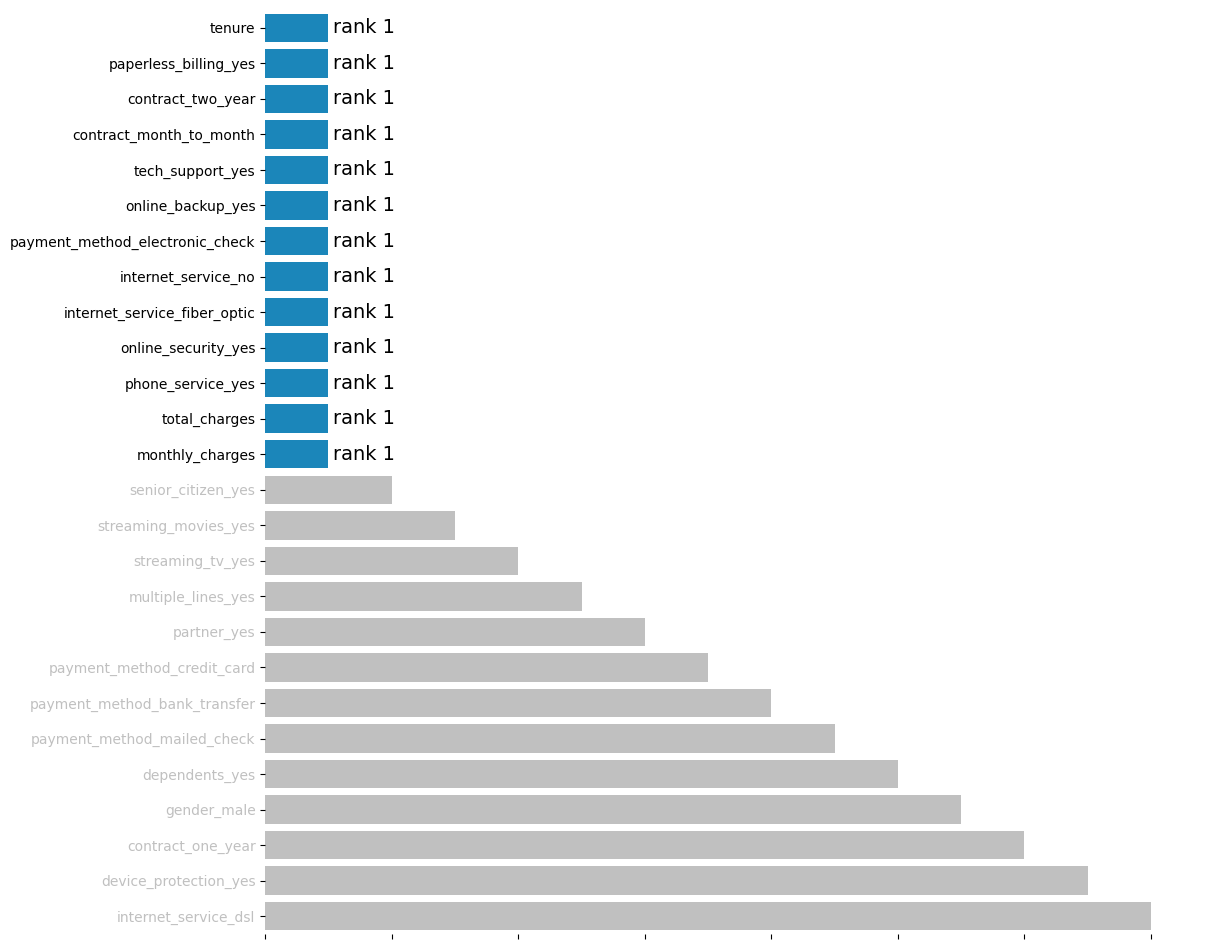

In [88]:
# viz
selected_feature = wrapper.get_feature_names_out()
feature_name = wrapper.feature_names_in_
feature_ranking = wrapper.ranking_

# add to dataframe
feature_selection = pd.DataFrame({'feature_name':feature_name, 'feature_ranking':feature_ranking}).sort_values('feature_ranking', ascending=True)
feature_selection.reset_index(drop=True, inplace=True)

# create flag
feature_selection['selected'] = feature_selection['feature_ranking'].apply(lambda x: True if x == 1 else False)

# highlight the top features
palette = []
for i in range(0, len(feature_selection)):
  if i < threshold:
    palette.append('#008FD5')
  else:
    palette.append('silver')

fig, ax = plt.subplots(figsize=(12,12))

sns.barplot(data=feature_selection, x='feature_ranking', y='feature_name', ax=ax, palette=palette)
# ax.bar_label(ax.containers[0], padding=3, fmt='%.2f', fontsize=14, fontweight='medium')

# custom y label color
for i, label in enumerate(ax.yaxis.get_ticklabels()):
  if feature_selection.loc[i, 'selected'] == False:
    label.set_color('silver')

# custom bar label visibility
for con in ax.containers:
  # labels = [val for val in con.datavalues]
  labels = con.datavalues
  labels_len = len(labels)

  # masking the top features
  np.put(labels, np.arange(threshold,labels_len), [-1])

  # hide the labels for non-top features
  labels = [f'rank {val:.0f}' if val != -1 else '' for val in labels]

  ax.bar_label(con, labels=labels, padding=3, fontsize=14, fontweight='medium')

ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')

sns.despine(left=True, bottom=True)
plt.show()

In [89]:
y_pred_list = dict()

for name, model in model_list.items():
  model.fit(X_train_wrap, y_train_model)
  y_pred_list[name] = model.predict(X_test_wrap)

score_wrap = get_score(y_pred_list, y_test_model, average='macro')

[LightGBM] [Info] Number of positive: 3622, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 603
[LightGBM] [Info] Number of data points in the train set: 7244, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,accuracy,macro_avg_precision,macro_avg_recall,macro_avg_f1_score,roc_auc
model,,,,,
Gradient Boosting Classifier,0.752958,0.714908,0.764676,0.722012,0.764676
AdaBoost Classifier,0.748699,0.712737,0.763484,0.718702,0.763484
CatBoost Classifier,0.757690,0.709877,0.749686,0.719576,0.749686
Hist Gradient Boosting,0.747752,0.700614,0.740075,0.709356,0.740075
XGBoost,0.763370,0.707614,0.735341,0.717040,0.735341
LightGBM,0.755797,0.706596,0.744414,0.716232,0.744414


### 4.4.3 Embedded Method

In [90]:
estimator = LogisticRegression(random_state=1)

embedded = SelectFromModel(estimator=estimator, threshold='median')
embedded.fit(X_train_model, y_train_model)

X_train_embed = embedded.transform(X_train_model)
X_test_embed = embedded.transform(X_test_scale)

print('before embedded\t:', X_train_model.shape)
print('after embedded\t:', X_train_embed.shape)

before embedded	: (7244, 26)
after embedded	: (7244, 13)


threshold: 0.254


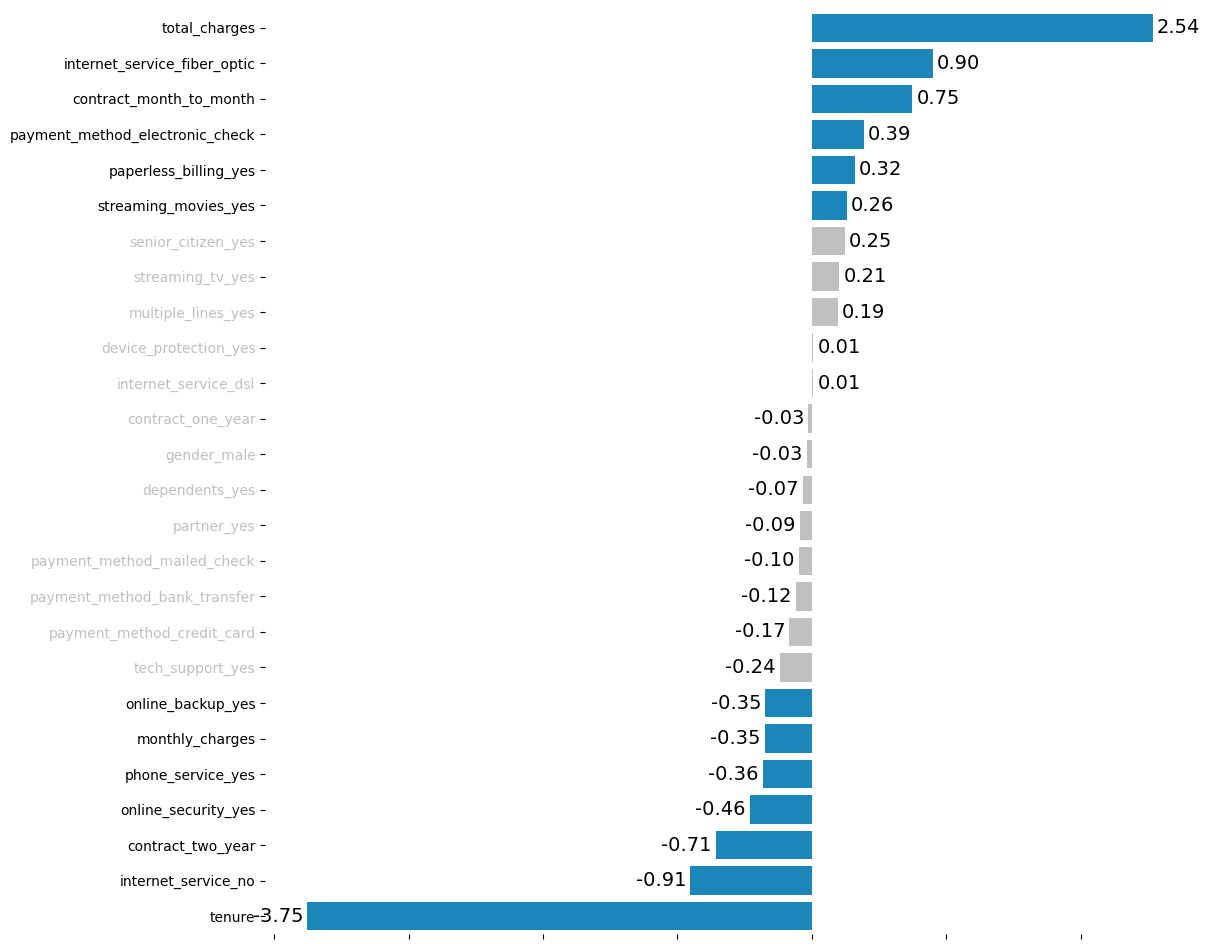

In [91]:
# viz
# selected_feature = embedded.get_feature_names_out()
feature_name = embedded.feature_names_in_
feature_importance = embedded.estimator_.coef_[0]

# add to dataframe
feature_selection = pd.DataFrame({'feature_name':feature_name, 'feature_importance':feature_importance}).sort_values('feature_importance', ascending=False)
feature_selection.reset_index(drop=True, inplace=True)

# create flag
threshold = embedded.threshold_
print(f'threshold: {threshold:.3f}')
feature_selection['selected'] = feature_selection['feature_importance'].apply(lambda x: True if (abs(x) > threshold) else False)

# highlight the top features
palette = []
for flag in feature_selection['selected']:
  if flag:
    palette.append('#008FD5')
  else:
    palette.append('silver')

fig, ax = plt.subplots(figsize=(12,12))

# sns.barplot(x=corr_target.values, y=corr_target.index, ax=ax, palette=palette)
sns.barplot(data=feature_selection, x='feature_importance', y='feature_name', ax=ax, palette=palette)
ax.bar_label(ax.containers[0], padding=3, fmt='%.2f', fontsize=14, fontweight='medium')

# custom y label color
for i, label in enumerate(ax.yaxis.get_ticklabels()):
  if feature_selection.loc[i, 'selected'] == False:
    label.set_color('silver')

ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')

sns.despine(left=True, bottom=True)
plt.show()

In [92]:
y_pred_list = dict()

for name, model in model_list.items():
  model.fit(X_train_embed, y_train_model)
  y_pred_list[name] = model.predict(X_test_embed)

score_embed = get_score(y_pred_list, y_test_model, average='macro')

[LightGBM] [Info] Number of positive: 3622, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 603
[LightGBM] [Info] Number of data points in the train set: 7244, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,accuracy,macro_avg_precision,macro_avg_recall,macro_avg_f1_score,roc_auc
model,,,,,
Gradient Boosting Classifier,0.744912,0.706083,0.753508,0.712652,0.753508
AdaBoost Classifier,0.743019,0.708740,0.759618,0.713524,0.759618
CatBoost Classifier,0.750592,0.703919,0.744285,0.712855,0.744285
Hist Gradient Boosting,0.752011,0.703503,0.741837,0.712771,0.741837
XGBoost,0.747752,0.692837,0.722433,0.701730,0.722433
LightGBM,0.756271,0.708976,0.749289,0.718499,0.749289


### 4.4.4 Comparison

In [93]:
score_smote_mean = pd.DataFrame(score_smote.mean(), columns=['original']).T
score_filter_mean = pd.DataFrame(score_filter.mean(), columns=['filter method']).T
score_wrap_mean = pd.DataFrame(score_wrap.mean(), columns=['wrapper method']).T
score_embed_mean = pd.DataFrame(score_embed.mean(), columns=['embedded method']).T

score_compare = pd.concat([score_smote_mean,
                           score_filter_mean,
                           score_wrap_mean,
                           score_embed_mean], axis=0)

score_compare.style.background_gradient(axis=0)

,accuracy,macro_avg_precision,macro_avg_recall,macro_avg_f1_score,roc_auc
original,0.756428,0.709007,0.747310,0.717437,0.747310
filter method,0.752879,0.707265,0.747739,0.715463,0.747739
wrapper method,0.754378,0.708724,0.749613,0.717153,0.749613
embedded method,0.749093,0.704010,0.745162,0.712005,0.745162


## 4.5. Hyperparameter Tuning

In [94]:
model_list = {
    'Gradient Boosting Classifier':GradientBoostingClassifier(random_state=1),
    'AdaBoost Classifier':AdaBoostClassifier(random_state=1),
    'CatBoost Classifier':CatBoostClassifier(random_state=1, verbose=False),
    'Hist Gradient Boosting':HistGradientBoostingClassifier(random_state=1),
    'XGBoost':XGBClassifier(random_state=1, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM':LGBMClassifier(random_state=1),
}

In [95]:
model_list_tuned = {
    'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=1,
                                                              max_depth=2,
                                                              n_estimators=500,
                                                              learning_rate=0.02),

    'AdaBoost Classifier': AdaBoostClassifier(
                                            random_state=1,
                                            n_estimators=80,
                                            learning_rate=0.04
                                        ),

    'CatBoost Classifier': CatBoostClassifier(random_state=1, verbose=False,
                                             n_estimators=1000,
                                             learning_rate=0.004,
                                             scale_pos_weight=1.1),

    'Hist Gradient Boosting': HistGradientBoostingClassifier(random_state=1,
                                                            max_iter=200,
                                                            learning_rate=0.01,
                                                            max_depth=5),

    'XGBoost': XGBClassifier(random_state=1, use_label_encoder=False, eval_metric='logloss',
                            colsample_bytree=0.1,
                            learning_rate=0.005),

    'LightGBM': LGBMClassifier(random_state=1,
                              num_leaves=10,
                              n_estimators=175,
                              learning_rate=0.01)
}

### 4.5.1 without feature selection (original)

In [96]:
y_pred_list = dict()

for name, model in model_list.items():
  model.fit(X_train_model, y_train_model)
  y_pred_list[name] = model.predict(X_test_model)

score_no_fs_not_tuned = get_score(y_pred_list, y_test_model)

c:\Users\HP\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:21:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 3622, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 629
[LightGBM] [Info] Number of data points in the train set: 7244, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,accuracy,precision,recall,f1_score,roc_auc
model,,,,,
Gradient Boosting Classifier,0.752011,0.521998,0.782531,0.626248,0.761755
AdaBoost Classifier,0.743019,0.510251,0.798574,0.622655,0.760756
CatBoost Classifier,0.768575,0.548518,0.725490,0.624712,0.754820
Hist Gradient Boosting,0.759110,0.534574,0.716578,0.612338,0.745531
XGBoost,0.757690,0.536082,0.648841,0.587097,0.722939
LightGBM,0.758164,0.534247,0.695187,0.604183,0.738058


In [97]:
y_pred_list = dict()

for name, model in model_list_tuned.items():
  model.fit(X_train_model, y_train_model)
  y_pred_list[name] = model.predict(X_test_model)

score_no_fs_tuned = get_score(y_pred_list, y_test_model)

c:\Users\HP\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:22:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 3622, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 629
[LightGBM] [Info] Number of data points in the train set: 7244, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,accuracy,precision,recall,f1_score,roc_auc
model,,,,,
Gradient Boosting Classifier,0.747279,0.515429,0.803922,0.628134,0.765363
AdaBoost Classifier,0.737340,0.503297,0.816399,0.622706,0.762581
CatBoost Classifier,0.739233,0.505568,0.809269,0.622344,0.761593
Hist Gradient Boosting,0.744439,0.512139,0.789661,0.621318,0.758877
XGBoost,0.744912,0.513064,0.770053,0.615823,0.752939
LightGBM,0.745386,0.513083,0.803922,0.626389,0.764074


In [98]:
score_compare = score_no_fs_not_tuned.loc[:, ['accuracy', 'recall', 'roc_auc']]
score_compare = score_compare.join(score_no_fs_tuned.loc[:, ['accuracy', 'recall', 'roc_auc']],
                                   lsuffix='_not_tuned', rsuffix='_tuned')

score_compare.style.background_gradient(axis=1)


,accuracy_not_tuned,recall_not_tuned,roc_auc_not_tuned,accuracy_tuned,recall_tuned,roc_auc_tuned
model,,,,,,
Gradient Boosting Classifier,0.752011,0.782531,0.761755,0.747279,0.803922,0.765363
AdaBoost Classifier,0.743019,0.798574,0.760756,0.737340,0.816399,0.762581
CatBoost Classifier,0.768575,0.725490,0.754820,0.739233,0.809269,0.761593
Hist Gradient Boosting,0.759110,0.716578,0.745531,0.744439,0.789661,0.758877
XGBoost,0.757690,0.648841,0.722939,0.744912,0.770053,0.752939
LightGBM,0.758164,0.695187,0.738058,0.745386,0.803922,0.764074


### 4.5.2 feature selection (filter method)

In [99]:
y_pred_list = dict()

for name, model in model_list.items():
  model.fit(X_train_filter, y_train_model)
  y_pred_list[name] = model.predict(X_test_filter)

score_fs_not_tuned = get_score(y_pred_list, y_test_model)

c:\Users\HP\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:22:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 3622, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 603
[LightGBM] [Info] Number of data points in the train set: 7244, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,accuracy,precision,recall,f1_score,roc_auc
model,,,,,
Gradient Boosting Classifier,0.751065,0.520759,0.782531,0.625356,0.761111
AdaBoost Classifier,0.743966,0.511468,0.795009,0.622470,0.760262
CatBoost Classifier,0.754851,0.527886,0.725490,0.611111,0.745477
Hist Gradient Boosting,0.751065,0.522465,0.725490,0.607463,0.742900
XGBoost,0.766682,0.549275,0.675579,0.605915,0.737596
LightGBM,0.749645,0.520725,0.716578,0.603151,0.739088


In [100]:
y_pred_list = dict()

for name, model in model_list_tuned.items():
  model.fit(X_train_filter, y_train_model)
  y_pred_list[name] = model.predict(X_test_filter)

score_fs_tuned = get_score(y_pred_list, y_test_model)

c:\Users\HP\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:23:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 3622, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 603
[LightGBM] [Info] Number of data points in the train set: 7244, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,accuracy,precision,recall,f1_score,roc_auc
model,,,,,
Gradient Boosting Classifier,0.749645,0.518307,0.807487,0.631359,0.768112
AdaBoost Classifier,0.737340,0.503297,0.816399,0.622706,0.762581
CatBoost Classifier,0.735447,0.501104,0.809269,0.618950,0.759016
Hist Gradient Boosting,0.747752,0.516241,0.793226,0.625439,0.762270
XGBoost,0.735920,0.501672,0.802139,0.617284,0.757062
LightGBM,0.747279,0.515535,0.798574,0.626573,0.763656


In [101]:
score_compare = score_fs_not_tuned.loc[:, ['accuracy', 'recall', 'roc_auc']]
score_compare = score_compare.join(score_fs_tuned.loc[:, ['accuracy', 'recall', 'roc_auc']],
                                   lsuffix='_not_tuned', rsuffix='_tuned')

score_compare.style.background_gradient(axis=1)


,accuracy_not_tuned,recall_not_tuned,roc_auc_not_tuned,accuracy_tuned,recall_tuned,roc_auc_tuned
model,,,,,,
Gradient Boosting Classifier,0.751065,0.782531,0.761111,0.749645,0.807487,0.768112
AdaBoost Classifier,0.743966,0.795009,0.760262,0.737340,0.816399,0.762581
CatBoost Classifier,0.754851,0.725490,0.745477,0.735447,0.809269,0.759016
Hist Gradient Boosting,0.751065,0.725490,0.742900,0.747752,0.793226,0.762270
XGBoost,0.766682,0.675579,0.737596,0.735920,0.802139,0.757062
LightGBM,0.749645,0.716578,0.739088,0.747279,0.798574,0.763656


## 4.6. Model Selection

In [102]:
from joblib import dump

# Train model
best_model = LGBMClassifier(random_state=1,
                            num_leaves=10,
                            n_estimators=175,
                            learning_rate=0.01)

best_model.fit(X_train_filter, y_train_model)

# Lưu model
dump(best_model, 'lightgbm_churn_model.pkl')

# Đường dẫn thư mục
# save_path = '/content/drive/MyDrive/1_TTTN_KLTN'

# Lưu mô hình LightGBM
dump(best_model, f'lightgbm_churn_model_ver1.pkl')

# Lưu feature selector
dump(filter, f'feature_selector.pkl')


[LightGBM] [Info] Number of positive: 3622, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 603
[LightGBM] [Info] Number of data points in the train set: 7244, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


['feature_selector.pkl']

In [ ]:
selected_columns = X_train_model.columns[wrapper.get_support()]

In [104]:
print(selected_columns.tolist())

['tenure', 'monthly_charges', 'total_charges', 'dependents_yes', 'internet_service_fiber_optic', 'internet_service_no', 'online_security_yes', 'tech_support_yes', 'contract_month_to_month', 'contract_one_year', 'contract_two_year', 'paperless_billing_yes', 'payment_method_electronic_check']


# Model - PREDICT PROBABILITY

In [105]:
from sklearn.metrics import log_loss, brier_score_loss

In [106]:
prob_model_list = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=1),
    'SVC': SVC(probability=True, random_state=1),
    'Neural Network': MLPClassifier(max_iter=1000, random_state=1),
    'Decision Tree': DecisionTreeClassifier(random_state=1),
    'Random Forest': RandomForestClassifier(random_state=1),
    'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=1),
    'AdaBoost Classifier': AdaBoostClassifier(random_state=1),
    'CatBoost Classifier': CatBoostClassifier(random_state=1, verbose=False),
    'Hist Gradient Boosting': HistGradientBoostingClassifier(random_state=1),
    'XGBoost': XGBClassifier(random_state=1, eval_metric='logloss', use_label_encoder=False),
    'LightGBM': LGBMClassifier(random_state=1),
}

In [107]:
results = []

for name, model in prob_model_list.items():
    model.fit(X_train_model, y_train_model)

    # Predict xác suất thuộc class 1
    y_proba = model.predict_proba(X_test_model)[:, 1]

    # Tính các metrics đánh giá
    auc = roc_auc_score(y_test_model, y_proba)
    logloss = log_loss(y_test_model, y_proba)
    brier = brier_score_loss(y_test_model, y_proba)

    results.append({
        'Model': name,
        'AUC': auc,
        'Log Loss': logloss,
        'Brier Score': brier
    })

df_metrics = pd.DataFrame(results).sort_values(by='AUC', ascending=False).reset_index(drop=True)


c:\Users\HP\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:25:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 3622, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 629
[LightGBM] [Info] Number of data points in the train set: 7244, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [108]:
df_metrics

,Model,AUC,Log Loss,Brier Score
0,Gradient Boosting Classifier,0.841722,0.477267,0.160293
1,Logistic Regression,0.840011,0.491846,0.165909
2,AdaBoost Classifier,0.837566,0.679341,0.243114
3,CatBoost Classifier,0.832896,0.473272,0.157518
4,LightGBM,0.830182,0.474102,0.157556
5,Hist Gradient Boosting,0.826548,0.483140,0.160371
6,SVC,0.816396,0.514095,0.171820
7,Random Forest,0.816238,0.590024,0.151783
8,XGBoost,0.810838,0.533307,0.167488
9,Neural Network,0.787083,0.685956,0.200938


In [109]:
df_metrics.style.format({
    'AUC': "{:.3f}",
    'Log Loss': "{:.3f}",
    'Brier Score': "{:.3f}"
}).background_gradient(
    subset=['AUC'], cmap='Greens'
).background_gradient(
    subset=['Log Loss'], cmap='Oranges_r'
).background_gradient(
    subset=['Brier Score'], cmap='Blues')


,Model,AUC,Log Loss,Brier Score
0,Gradient Boosting Classifier,0.842,0.477,0.160
1,Logistic Regression,0.840,0.492,0.166
2,AdaBoost Classifier,0.838,0.679,0.243
3,CatBoost Classifier,0.833,0.473,0.158
4,LightGBM,0.830,0.474,0.158
5,Hist Gradient Boosting,0.827,0.483,0.160
6,SVC,0.816,0.514,0.172
7,Random Forest,0.816,0.590,0.152
8,XGBoost,0.811,0.533,0.167
9,Neural Network,0.787,0.686,0.201


## 5.2. with feature selection

In [110]:
fs_results = []
for name, model in prob_model_list.items():
    model.fit(X_train_wrap, y_train_model)

    # Predict xác suất thuộc class 1
    y_proba = model.predict_proba(X_test_wrap)[:, 1]

    # Tính các metrics đánh giá
    auc = roc_auc_score(y_test_model, y_proba)
    logloss = log_loss(y_test_model, y_proba)
    brier = brier_score_loss(y_test_model, y_proba)

    fs_results.append({
        'Model': name,
        'AUC': auc,
        'Log Loss': logloss,
        'Brier Score': brier
    })

df_metrics_fs = pd.DataFrame(fs_results).sort_values(by='AUC', ascending=False).reset_index(drop=True)


c:\Users\HP\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:26:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 3622, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 603
[LightGBM] [Info] Number of data points in the train set: 7244, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [111]:
df_metrics_fs.style.format({
    'AUC': "{:.3f}",
    'Log Loss': "{:.3f}",
    'Brier Score': "{:.3f}"
}).background_gradient(
    subset=['AUC'], cmap='Greens'
).background_gradient(
    subset=['Log Loss'], cmap='Oranges_r'
).background_gradient(
    subset=['Brier Score'], cmap='Blues')


,Model,AUC,Log Loss,Brier Score
0,Gradient Boosting Classifier,0.843,0.479,0.161
1,Neural Network,0.840,0.476,0.158
2,Logistic Regression,0.839,0.494,0.167
3,AdaBoost Classifier,0.838,0.679,0.243
4,CatBoost Classifier,0.834,0.475,0.159
5,LightGBM,0.828,0.484,0.161
6,Hist Gradient Boosting,0.826,0.488,0.162
7,XGBoost,0.820,0.507,0.164
8,SVC,0.811,0.531,0.177
9,Random Forest,0.809,0.651,0.161


## 5.3. hyperparameter tuning

In [112]:
prob_model_list_tuned = {
    'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=1,
                                                              max_depth=2,
                                                              n_estimators=500,
                                                              learning_rate=0.02),

    'AdaBoost Classifier': AdaBoostClassifier(
                                            random_state=1,
                                            n_estimators=80,
                                            learning_rate=0.04
                                        ),

    'CatBoost Classifier': CatBoostClassifier(random_state=1, verbose=False,
                                             n_estimators=1000,
                                             learning_rate=0.004,
                                             scale_pos_weight=1.1),

    'Hist Gradient Boosting': HistGradientBoostingClassifier(random_state=1,
                                                            max_iter=200,
                                                            learning_rate=0.01,
                                                            max_depth=5),

    'XGBoost': XGBClassifier(random_state=1, use_label_encoder=False, eval_metric='logloss',
                            colsample_bytree=0.1,
                            learning_rate=0.005),

    'LightGBM': LGBMClassifier(random_state=1,
                              num_leaves=10,
                              n_estimators=175,
                              learning_rate=0.01)
}

In [113]:
fs_tuned_results = []
for name, model in prob_model_list_tuned.items():
    model.fit(X_train_wrap, y_train_model)

    # Predict xác suất thuộc class 1
    y_proba = model.predict_proba(X_test_wrap)[:, 1]

    # Tính các metrics đánh giá
    auc = roc_auc_score(y_test_model, y_proba)
    logloss = log_loss(y_test_model, y_proba)
    brier = brier_score_loss(y_test_model, y_proba)

    fs_tuned_results.append({
        'Model': name,
        'AUC': auc,
        'Log Loss': logloss,
        'Brier Score': brier
    })

df_metrics_fs_tuned = pd.DataFrame(fs_tuned_results).sort_values(by='AUC', ascending=False).reset_index(drop=True)

c:\Users\HP\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:26:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 3622, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 603
[LightGBM] [Info] Number of data points in the train set: 7244, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [114]:
df_metrics_fs_tuned.style.format({
    'AUC': "{:.3f}",
    'Log Loss': "{:.3f}",
    'Brier Score': "{:.3f}"
}).background_gradient(
    subset=['AUC'], cmap='Greens'
).background_gradient(
    subset=['Log Loss'], cmap='Oranges_r'
).background_gradient(
    subset=['Brier Score'], cmap='Blues')


,Model,AUC,Log Loss,Brier Score
0,Gradient Boosting Classifier,0.845,0.484,0.162
1,CatBoost Classifier,0.844,0.493,0.167
2,Hist Gradient Boosting,0.841,0.490,0.163
3,LightGBM,0.839,0.504,0.167
4,XGBoost,0.839,0.654,0.231
5,AdaBoost Classifier,0.829,0.602,0.206


# temp

In [115]:
gb_model = prob_model_list['Gradient Boosting Classifier']

In [1]:
import shap

In [118]:
# SHAP yêu cầu dữ liệu không bị chuẩn hóa hay biến đổi kiểu lạ
# Tùy phiên bản SHAP và scikit-learn, có thể dùng TreeExplainer với GradientBoosting
explainer = shap.Explainer(gb_model, X_train_wrap)

shap_values = explainer(y_test_model)


: 

In [129]:
X_train_wrap

array([[0.56944444, 0.09238555, 1.        , ..., 1.        , 0.        ,
        0.        ],
       [0.25      , 0.21143262, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.98611111, 0.54678289, 1.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.01388889, 0.00804959, 1.        , ..., 0.        , 1.        ,
        1.        ],
       [0.26086422, 0.18123941, 1.        , ..., 0.        , 0.        ,
        1.        ],
       [0.28948336, 0.21522516, 1.        , ..., 0.        , 1.        ,
        1.        ]])

In [105]:
# pip install dython

In [109]:
# numerical
new_column_numerical = ['tenure', 'monthly_charges', 'total_charges', 'amt_service_used']

#categorical
new_column_categorical = list(df_new.columns)
new_column_categorical.remove('tenure')
new_column_categorical.remove('monthly_charges')
new_column_categorical.remove('total_charges')
new_column_categorical.remove('amt_service_used')

<ipython-input-110-f110a3446504>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_target.values, y=corr_target.index, ax=ax, palette=palette, saturation=1)


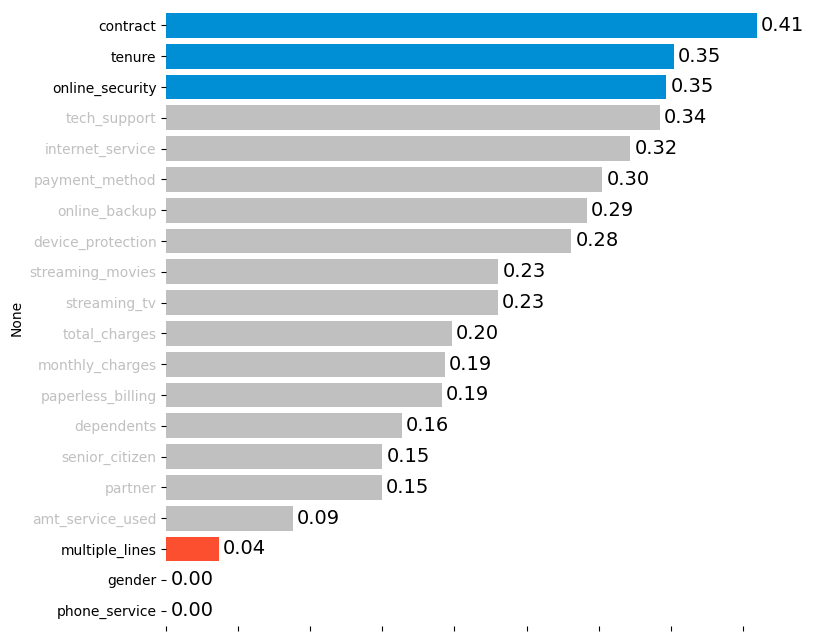

In [110]:
from dython.nominal import associations
# calculate the associations (correlation) between features
associations_out = associations(df_new,
                                nominal_columns=new_column_categorical,
                                numerical_columns=new_column_numerical,
                                nom_nom_assoc='cramer',
                                compute_only=True)

# the output is a dict {'ax', 'corr'}
corr_all = associations_out['corr']

corr_target = corr_all['churn'].drop('churn').sort_values(ascending=False)

# custom palette top 3
threshold_top = 3
threshold_bot = corr_target.size - 3 - 1
palette = []
for i in range(0, len(corr_target)):
  if i < threshold_top:
    palette.append('#008FD5') # blue
  elif i > threshold_bot:
    palette.append('#FC4F30') # red
  else:
    palette.append('silver')

fig, ax = plt.subplots(figsize=(8,8))

sns.barplot(x=corr_target.values, y=corr_target.index, ax=ax, palette=palette, saturation=1)
# ax.bar_label(ax.containers[0], padding=3, fmt='%.2f', fontsize=14, fontweight='medium')

# custom y label color
for i, label in enumerate(ax.yaxis.get_ticklabels()):
  if (i >= threshold_top) and (i <= threshold_bot):
    label.set_color('silver')

# custom bar label visibility
for con in ax.containers:
  # labels = [val for val in con.datavalues]
  labels = con.datavalues
  labels_len = len(labels)

  # masking the top 3 an bottom 3
  np.put(labels, np.arange(3,labels_len-3), [-1])

  # hide the labels for non-top 3 and non-bottom 3
  labels = [f'{val:.2f}' if val != -1 else '' for val in labels]

  ax.bar_label(con, labels=labels, padding=3, fontsize=14, fontweight='medium')

ax.set_xticklabels([])
sns.despine(left=True, bottom=True)
plt.show()

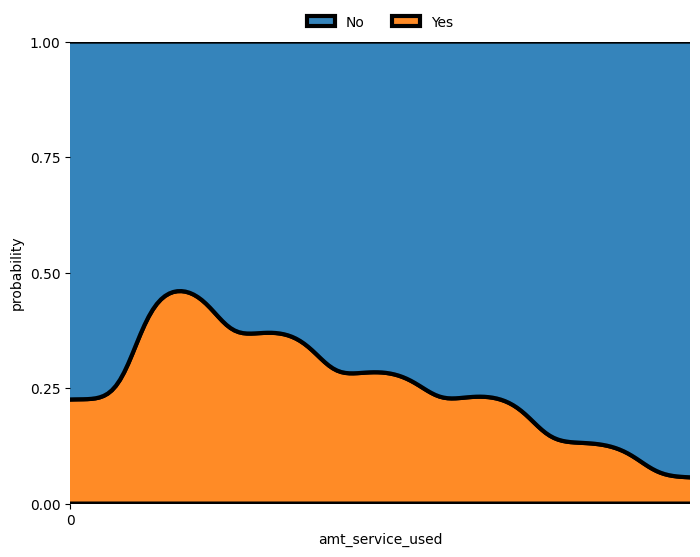

In [112]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid(False, axis='x')
sns.kdeplot(data=df_new, x='amt_service_used', hue='churn', multiple='fill', linewidth=3, ax=ax, alpha=0.9)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, 1), title='', ncol=2, frameon=False)

ax.set_xticks(np.arange(0,df_new['amt_service_used'].max(),10))
ax.set_xlim(df_new['amt_service_used'].min(),df_new['amt_service_used'].max())

ax.set_yticks(np.linspace(0,1,5))
ax.set_ylabel('probability')
ax.set_xlabel('amt_service_used')

sns.despine(left=True, bottom=True)

# ax.axis('tight')
plt.show()

In [77]:
distinct_pairs = df[['phone_service', 'internet_service']].drop_duplicates()
print(distinct_pairs)


   phone_service internet_service
0             No              DSL
1            Yes              DSL
4            Yes      Fiber optic
11           Yes               No


In [17]:
df.describe(include='O')

,gender,partner,dependents,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174


In [18]:
variation_categorical = dict()

for col in column_categorical:
  tmp = df[col].unique().tolist()
  tmp.sort()
  variation_categorical[col] = ', '.join(str(item) for item in tmp)

tmp = pd.Series(variation_categorical)
data_variation_categorical = pd.DataFrame(tmp).T.rename({0:'data variation'})
data_variation_categorical

,gender,senior_citizen,partner,dependents,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,churn
data variation,"Female, Male","0, 1","No, Yes","No, Yes","No, Yes","No, No phone service, Yes","DSL, Fiber optic, No","No, No internet service, Yes","No, No internet service, Yes","No, No internet service, Yes","No, No internet service, Yes","No, No internet service, Yes","No, No internet service, Yes","Month-to-month, One year, Two year","No, Yes","Bank transfer (automatic), Credit card (automa...","No, Yes"


## correlation  matrix

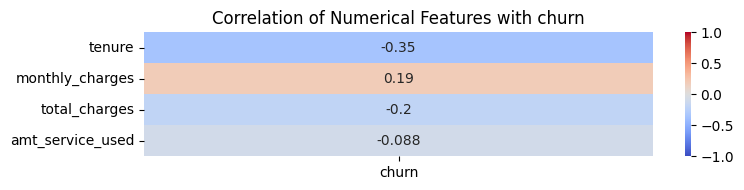

In [116]:
df_new['churn'] = df_new['churn'].map({'Yes': 1, 'No': 0})

target_col = 'churn'  # thay bằng tên cột mục tiêu của bạn

# Tạo dataframe chỉ gồm các biến số + biến mục tiêu
df_corr = df_new[new_column_numerical + [target_col]]

# Tính correlation matrix
corr_matrix = df_corr.corr()

# Vẽ heatmap chỉ thể hiện mối tương quan với biến mục tiêu
plt.figure(figsize=(8, len(column_numerical)*0.5))
sns.heatmap(corr_matrix[[target_col]].drop(target_col), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title(f'Correlation of Numerical Features with {target_col}')
plt.tight_layout()
plt.show()

## new feature

In [88]:
df_new = df.copy()
service_cols = [
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies'
]
df_new['amt_service_used'] = df_new[service_cols].apply(lambda row: sum(row == 'Yes'), axis=1)


<ipython-input-91-809a9b5e8cac>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_new, x='amt_service_used', y='monthly_charges', palette='coolwarm')


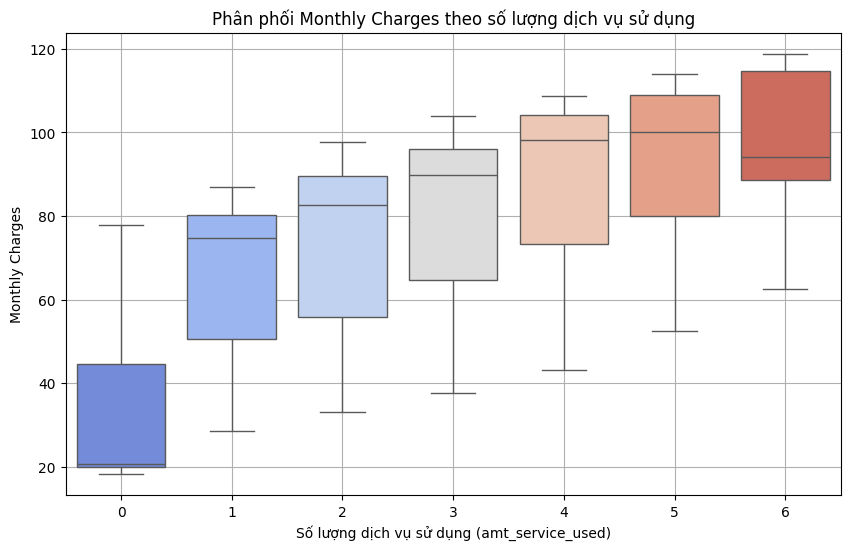

In [91]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_new, x='amt_service_used', y='monthly_charges', palette='coolwarm')
plt.title('Phân phối Monthly Charges theo số lượng dịch vụ sử dụng')
plt.xlabel('Số lượng dịch vụ sử dụng (amt_service_used)')
plt.ylabel('Monthly Charges')
plt.grid(True)
plt.show()


<ipython-input-92-10cd9e53d519>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_new, x='amt_service_used', y='tenure', palette='magma')


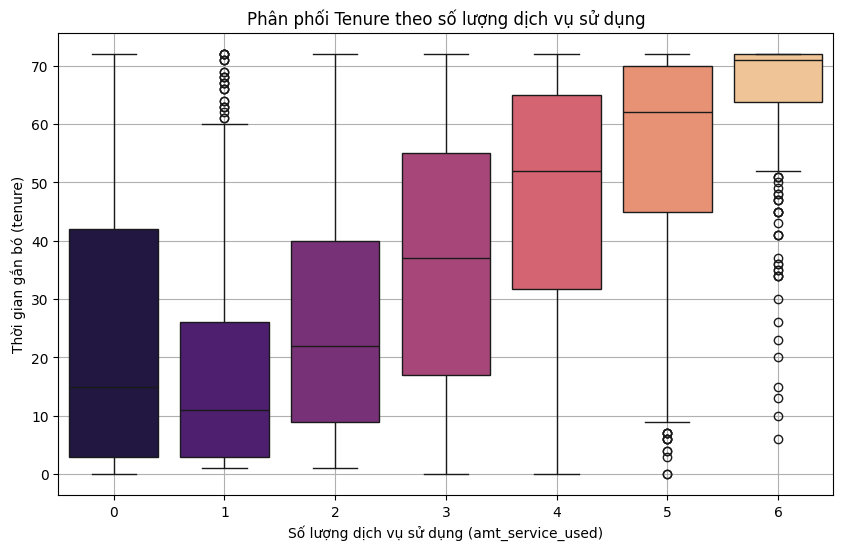

In [92]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_new, x='amt_service_used', y='tenure', palette='magma')
plt.title('Phân phối Tenure theo số lượng dịch vụ sử dụng')
plt.xlabel('Số lượng dịch vụ sử dụng (amt_service_used)')
plt.ylabel('Thời gian gắn bó (tenure)')
plt.grid(True)
plt.show()


## testing: phân cụm tenure

In [100]:
from sklearn.tree import DecisionTreeClassifier

df_testing = df.copy()
df_testing['churn_flag'] = df_testing['churn'].map({'Yes': 1, 'No': 0})

X = df_testing['tenure'].values.reshape(-1, 1)
y = df_testing['churn_flag'].values

tree = DecisionTreeClassifier(max_leaf_nodes=5, min_samples_leaf=100)
tree.fit(X, y)

thresholds = tree.tree_.threshold
thresholds = thresholds[thresholds != -2]  # loại bỏ các giá trị không phải split

bins = np.sort(thresholds)
print("Điểm chia tenure (theo cây quyết định):", bins)

bin_edges = [0] + list(bins) + [df['tenure'].max()]
df['tenure_group'] = pd.cut(df['tenure'], bins=bin_edges, labels=False, include_lowest=True)


Điểm chia tenure (theo cây quyết định): [ 1.5  5.5 16.5 49.5]


In [102]:
df_testing.groupby('tenure_group')['churn_flag'].mean()

,churn_flag
tenure_group,
0,0.608974
1,0.487282
2,0.356234
3,0.218534
4,0.091118


In [99]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# Encode label churn
df_testing = df.copy()
df_testing['churn_flag'] = df_testing['churn'].map({'Yes': 1, 'No': 0})

X = df_testing[['tenure']]
y = df_testing['churn_flag']

tree = DecisionTreeClassifier(
    max_leaf_nodes=5,  # bạn có thể điều chỉnh số lượng nhóm tại đây
    min_samples_leaf=100,  # tránh overfitting
    random_state=42
)
tree.fit(X, y)

# Lấy điểm chia của cây
thresholds = tree.tree_.threshold
thresholds = thresholds[thresholds != -2]  # loại bỏ leaf nodes
thresholds = np.sort(thresholds)

print("Ngưỡng chia được tìm bởi Decision Tree:", thresholds)


Ngưỡng chia được tìm bởi Decision Tree: [ 1.5  5.5 16.5 49.5]


# Appendix

## giải thích thuật ngữ của internet_service

DSL – Viết tắt của Digital Subscriber Line, đây là loại kết nối internet sử dụng đường dây điện thoại nhưng vẫn có thể gọi điện cùng lúc.
→ Đây là hình thức kết nối băng thông rộng phổ biến ở các khu dân cư.

Fiber optic – Internet cáp quang, tốc độ cao hơn nhiều so với DSL.
→ Đây là lựa chọn thường dành cho khách hàng có nhu cầu cao về tốc độ (streaming, gaming, công việc online...).

No – Khách hàng không đăng ký dịch vụ Internet với Telco.
→ Trong trường hợp này, các dịch vụ liên quan đến Internet như OnlineSecurity, OnlineBackup, StreamingTV, v.v. sẽ thường mang giá trị 'No internet service'.

## func() combine df

In [171]:
def combine_encoded_data(X_train_encode, X_test_encode, y_train_encode, y_test_encode, target_name='churn'):
    """
    Kết hợp X_train và X_test đã encode, cùng với y_train và y_test,
    và xử lý tên cột cũng như NaN từ việc join.

    Parameters:
    - X_train_encode: DataFrame
    - X_test_encode: DataFrame
    - y_train_encode: Series hoặc array-like
    - y_test_encode: Series hoặc array-like
    - target_name: Tên cột mục tiêu (default: 'churn')

    Returns:
    - DataFrame đã kết hợp đầy đủ.
    """
    # Combine X
    data_encode = pd.concat([X_train_encode, X_test_encode], axis=0)

    # Add y_train và y_test bằng chỉ số đúng
    data_encode = data_encode.join(
        pd.Series(y_train_encode, name=target_name, index=X_train_encode.index),
        lsuffix='_1', rsuffix='_2'
    )
    data_encode = data_encode.join(
        pd.Series(y_test_encode, name=target_name, index=X_test_encode.index),
        lsuffix='_1', rsuffix='_2'
    )

    # Gộp cột churn
    data_encode[f'{target_name}_1'] = data_encode[f'{target_name}_1'].fillna(data_encode[f'{target_name}_2'])
    data_encode.drop(columns=f'{target_name}_2', inplace=True)
    data_encode.rename(columns={f'{target_name}_1': target_name}, inplace=True)

    return data_encode